In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import ipywidgets as widgets
from IPython.display import display
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import RobustScaler, StandardScaler, OneHotEncoder, LabelEncoder, OrdinalEncoder, PolynomialFeatures
from sklearn.linear_model import LinearRegression, LogisticRegression
from xgboost import XGBClassifier, plot_importance
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
#from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_validate, learning_curve, StratifiedKFold, RandomizedSearchCV, cross_val_predict, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
from sklearn.metrics import mean_squared_error, classification_report, mean_absolute_error, roc_curve, roc_auc_score, precision_recall_curve, r2_score, precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, make_scorer
from sklearn.inspection import permutation_importance
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
import warnings 
warnings.filterwarnings('ignore')
import shap
shap.initjs()

In [2]:
#Importation des données
df = pd.read_csv("churn-bigml-80.csv")

In [3]:
df.head()

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,KS,128,415,No,Yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,No,Yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,No,No,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,Yes,No,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,Yes,No,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


In [15]:
# Séparation des données en deux catégories : Numériques et catégorielle pour les utiliser ultérieurement

numeric_vars = df.select_dtypes(include=['int', 'float'])
categ_vars = df.select_dtypes(include=['object', 'boolean'])

In [5]:
df.shape

(2666, 20)

In [6]:
df['State'].unique()

array(['KS', 'OH', 'NJ', 'OK', 'AL', 'MA', 'MO', 'WV', 'RI', 'IA', 'MT',
       'ID', 'VT', 'VA', 'TX', 'FL', 'CO', 'AZ', 'NE', 'WY', 'IL', 'NH',
       'LA', 'GA', 'AK', 'MD', 'AR', 'WI', 'OR', 'DE', 'IN', 'UT', 'CA',
       'SD', 'NC', 'WA', 'MN', 'NM', 'NV', 'DC', 'NY', 'KY', 'ME', 'MS',
       'MI', 'SC', 'TN', 'PA', 'HI', 'ND', 'CT'], dtype=object)

In [5]:
# Description des données 

df.describe().T

,count,mean,std,min,25%,50%,75%,max
Account length,2666.0,100.620405,39.563974,1.00,73.0000,100.00,127.000,243.00
Area code,2666.0,437.438860,42.521018,408.00,408.0000,415.00,510.000,510.00
Number vmail messages,2666.0,8.021755,13.612277,0.00,0.0000,0.00,19.000,50.00
Total day minutes,2666.0,179.481620,54.210350,0.00,143.4000,179.95,215.900,350.80
Total day calls,2666.0,100.310203,19.988162,0.00,87.0000,101.00,114.000,160.00
Total day charge,2666.0,30.512404,9.215733,0.00,24.3800,30.59,36.700,59.64
Total eve minutes,2666.0,200.386159,50.951515,0.00,165.3000,200.90,235.100,363.70
Total eve calls,2666.0,100.023631,20.161445,0.00,87.0000,100.00,114.000,170.00
Total eve charge,2666.0,17.033072,4.330864,0.00,14.0500,17.08,19.980,30.91
Total night minutes,2666.0,201.168942,50.780323,43.70,166.9250,201.15,236.475,395.00


In [6]:
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
State,2666,51,WV,88,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Account length,2666.0,NaN,NaN,NaN,100.620405,39.563974,1.0,73.0,100.0,127.0,243.0
Area code,2666.0,NaN,NaN,NaN,437.43886,42.521018,408.0,408.0,415.0,510.0,510.0
International plan,2666,2,No,2396,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Voice mail plan,2666,2,No,1933,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Number vmail messages,2666.0,NaN,NaN,NaN,8.021755,13.612277,0.0,0.0,0.0,19.0,50.0
Total day minutes,2666.0,NaN,NaN,NaN,179.48162,54.21035,0.0,143.4,179.95,215.9,350.8
Total day calls,2666.0,NaN,NaN,NaN,100.310203,19.988162,0.0,87.0,101.0,114.0,160.0
Total day charge,2666.0,NaN,NaN,NaN,30.512404,9.215733,0.0,24.38,30.59,36.7,59.64
Total eve minutes,2666.0,NaN,NaN,NaN,200.386159,50.951515,0.0,165.3,200.9,235.1,363.7


In [9]:
df.dtypes

State                      object
Account length              int64
Area code                   int64
International plan         object
Voice mail plan            object
Number vmail messages       int64
Total day minutes         float64
Total day calls             int64
Total day charge          float64
Total eve minutes         float64
Total eve calls             int64
Total eve charge          float64
Total night minutes       float64
Total night calls           int64
Total night charge        float64
Total intl minutes        float64
Total intl calls            int64
Total intl charge         float64
Customer service calls      int64
Churn                        bool
dtype: object

In [9]:
print(df.isnull().sum())
print('\nLes données ne contiennent aucune valeur manquante')

State                     0
Account length            0
Area code                 0
International plan        0
Voice mail plan           0
Number vmail messages     0
Total day minutes         0
Total day calls           0
Total day charge          0
Total eve minutes         0
Total eve calls           0
Total eve charge          0
Total night minutes       0
Total night calls         0
Total night charge        0
Total intl minutes        0
Total intl calls          0
Total intl charge         0
Customer service calls    0
Churn                     0
dtype: int64

Les données ne contiennent aucune valeur manquante


<AxesSubplot:>

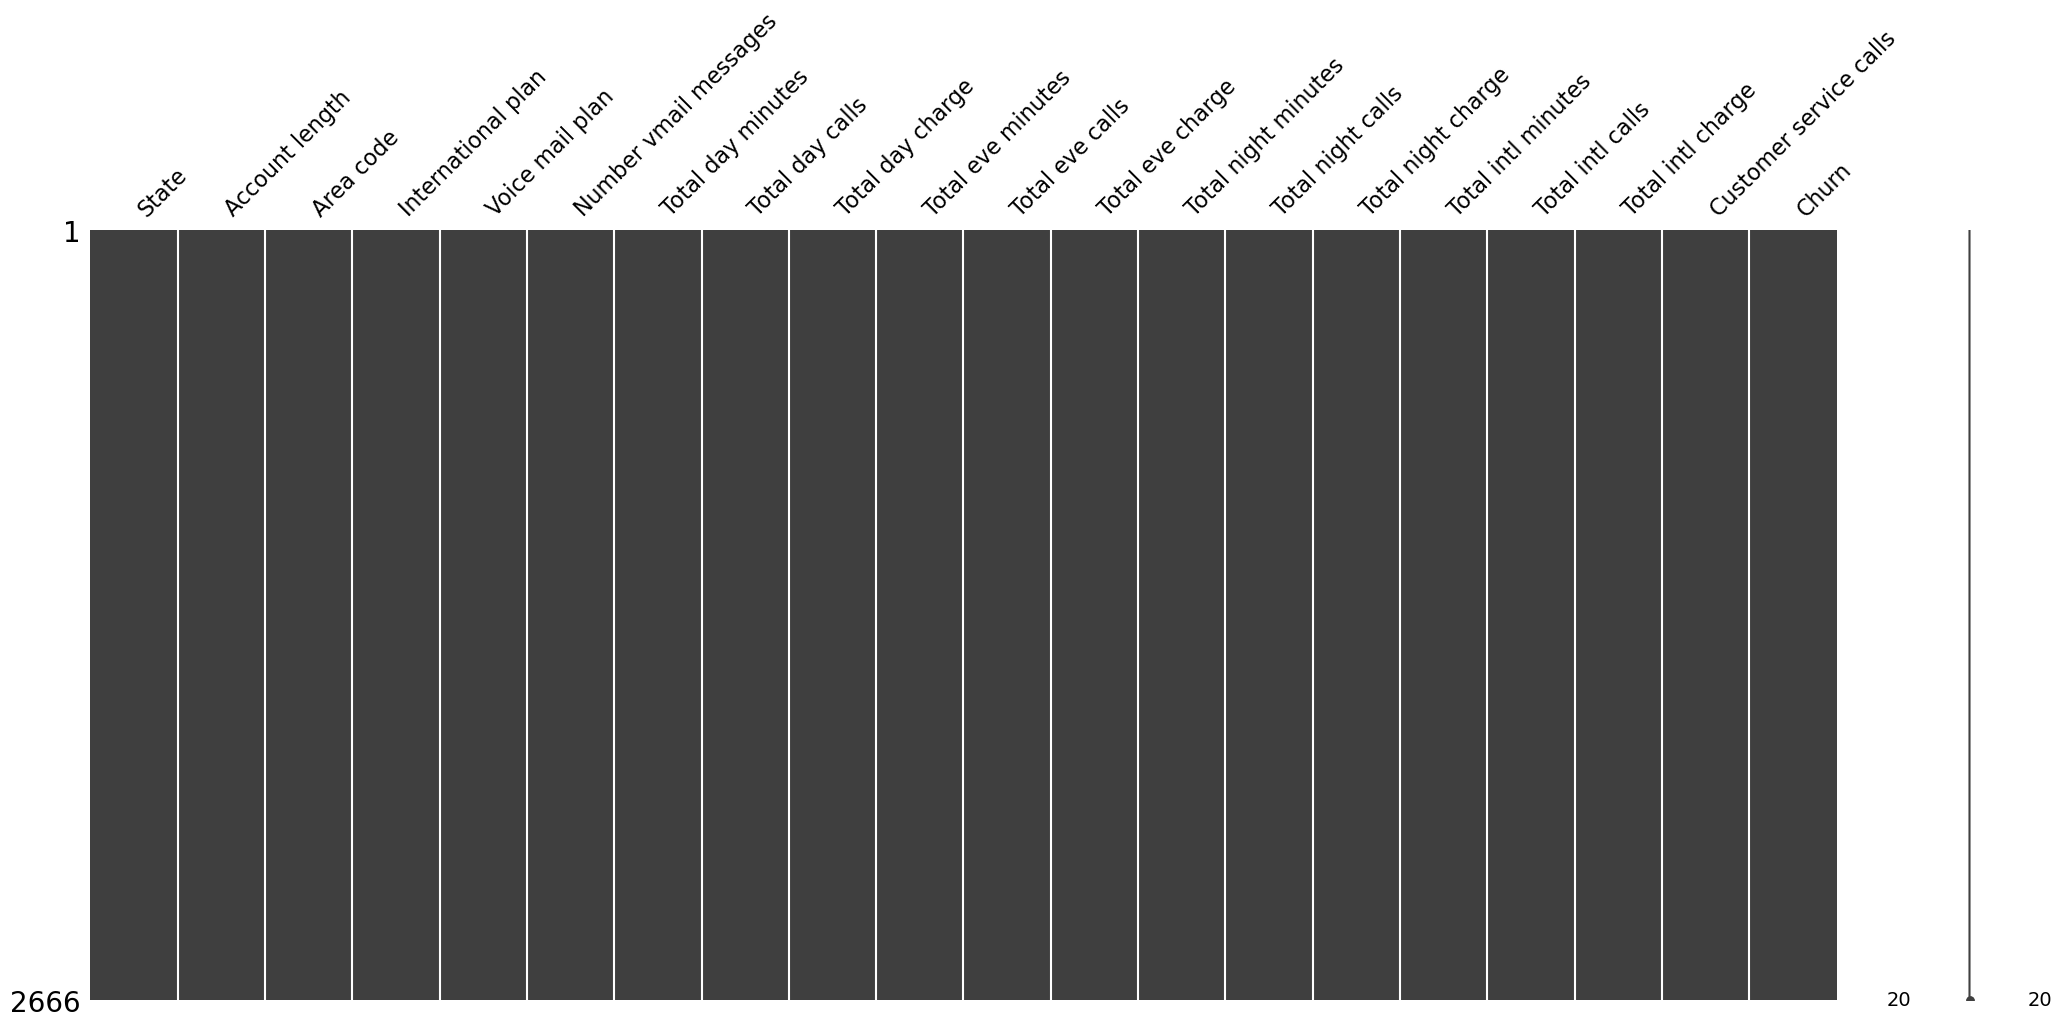

In [10]:
msno.matrix(df)

In [11]:
def plot_var(variable):
    plt.figure(figsize=(15,15))
    plt.plot(df[variable])
    plt.title(variable)
    plt.show()
    
variable_list = df.columns.tolist()
widgets.interact(plot_var, variable=variable_list)

interactive(children=(Dropdown(description='variable', options=('State', 'Account length', 'Area code', 'Inter…

<function __main__.plot_var(variable)>

In [13]:
# Représentation interactive de l'histogramme de différents caractéristiques du jeu de données

def hist_var(variable):
    plt.figure(figsize=(20,15))
    plt.hist(df[variable], bins=40)
    plt.title(variable)
    plt.show()
    
widgets.interact(hist_var, variable=variable_list)

interactive(children=(Dropdown(description='variable', options=('State', 'Account length', 'Area code', 'Inter…

<function __main__.hist_var(variable)>

# Interprétation des Histogrammes : 

La majorité des données numériques présentent une distribution normale, nous donne des informations sur la fréquence de chaque valeur de notre ensemble de données  on a ainsi une quasi-absence de valeurs aberrantes significatives.

In [18]:
# Représentation interactive de kde plot de différents caractéristiques du jeu de données

def kde_var(variable):
    plt.figure(figsize=(15,10))
    sns.kdeplot(df[variable])
    plt.title(variable)
    plt.show()
widgets.interact(kde_var, variable=numeric_vars)

interactive(children=(Dropdown(description='variable', options=('Account length', 'Area code', 'Number vmail m…

<function __main__.kde_var(variable)>

In [19]:
# Représentation interactive de kde plot en relation avec notre variable cible (Churn) de différents caractéristiques du jeu de données

def kde_churn(variable):
    plt.figure(figsize=(20,15))
    sns.kdeplot(df[variable], hue=df['Churn'], common_norm=False)
    plt.title(variable)
    plt.show()

widgets.interact(kde_churn, variable=numeric_vars)

interactive(children=(Dropdown(description='variable', options=('Account length', 'Area code', 'Number vmail m…

<function __main__.kde_churn(variable)>

# commentaires sur kdeplot 

Account length : on remarque que si 100 < Account length < 125 la probabilité de churn est élevée

Total day minutes : Total day minutes > 250 la proba de churn est élevée 

Total day charge : Total day charge > 40 le proba de churn est plus élevée

Total eve minutes : Total eve minutes > 250 proba de churn élevée 

Total eve charge : Total eve charge > 20 proba de churn élevée 

Total intl minutes : Total intl minutes > 12 pproba de churn élevée 

Total intl calls : entre 0 et 4 la proba de churn plus élevée 

Total intl charge : Total intl charge > 3 proba de churn élevée 

Customer service calls : Customer service calls > 3 proba de chuen élevée 

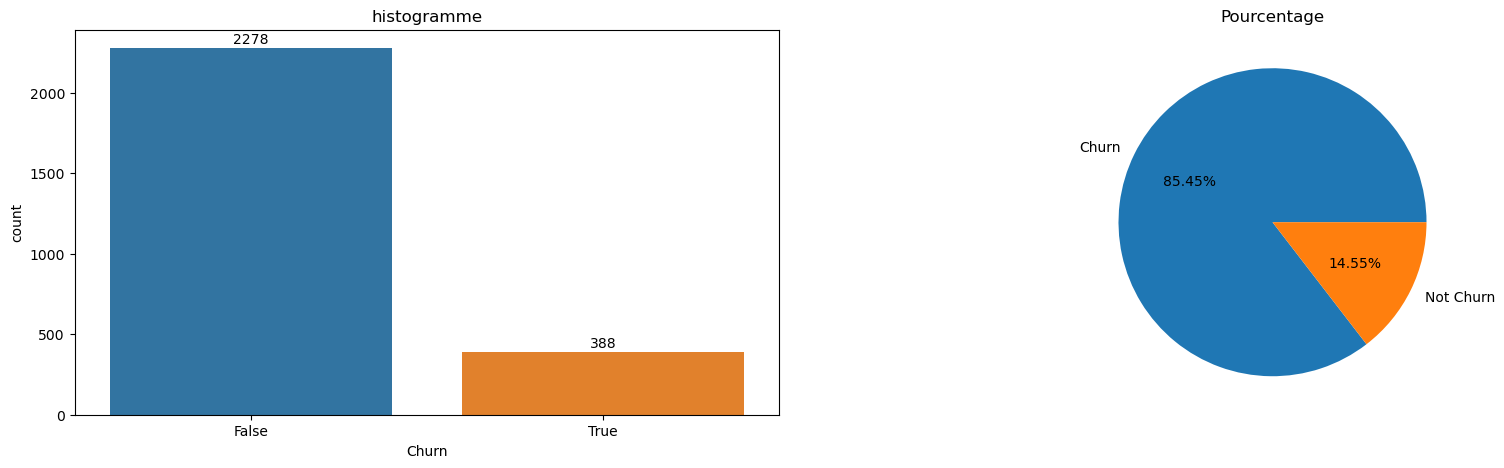

In [21]:
fix, axs = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))
sns.countplot(x="Churn", data=df, ax=axs[0])
# ajouter les compteurs de chaque bins
for index, count in enumerate(df["Churn"].value_counts()):
    axs[0].text(index, count+30, count, ha="center")
axs[0].set_title("histogramme")

# % target plot pie
grouped_churn = df['Churn'].value_counts()
axs[1].pie(grouped_churn, labels=['Churn', 'Not Churn'], autopct="%1.2f%%")
axs[1].set_title("Pourcentage")

plt.show()

Comme la distribution des classes de la variable cible "Attrition_Flag" est déséquilibrée, nous sommes confrontés à un problème de classification déséquilibré. Par conséquent, nous devrons ultérieurement appliquer des techniques visant à traiter des données déséquilibrées.

In [23]:
# Représentation interactive de kde plot en relation avec notre variable cible (Churn) de différents caractéristiques du jeu de données

def boxplot_var(column_name):
    plt.figure(figsize=(10, 8))
    plt.boxplot(df[column_name])
    plt.title(column_name)
    plt.show()
    
widgets.interact(boxplot_var, column_name=numeric_vars)

interactive(children=(Dropdown(description='column_name', options=('Account length', 'Area code', 'Number vmai…

<function __main__.boxplot_var(column_name)>

Pourcentage d'outliers pour Account length : 0.45%
Pourcentage d'outliers pour Area code : 0.0%
Pourcentage d'outliers pour Number vmail messages : 0.08%
Pourcentage d'outliers pour Total day minutes : 0.79%
Pourcentage d'outliers pour Total day calls : 0.68%
Pourcentage d'outliers pour Total day charge : 0.79%
Pourcentage d'outliers pour Total eve minutes : 0.64%
Pourcentage d'outliers pour Total eve calls : 0.56%
Pourcentage d'outliers pour Total eve charge : 0.64%
Pourcentage d'outliers pour Total night minutes : 0.83%
Pourcentage d'outliers pour Total night calls : 0.71%
Pourcentage d'outliers pour Total night charge : 0.83%
Pourcentage d'outliers pour Total intl minutes : 1.39%
Pourcentage d'outliers pour Total intl calls : 2.48%
Pourcentage d'outliers pour Total intl charge : 1.5%
Pourcentage d'outliers pour Customer service calls : 7.88%


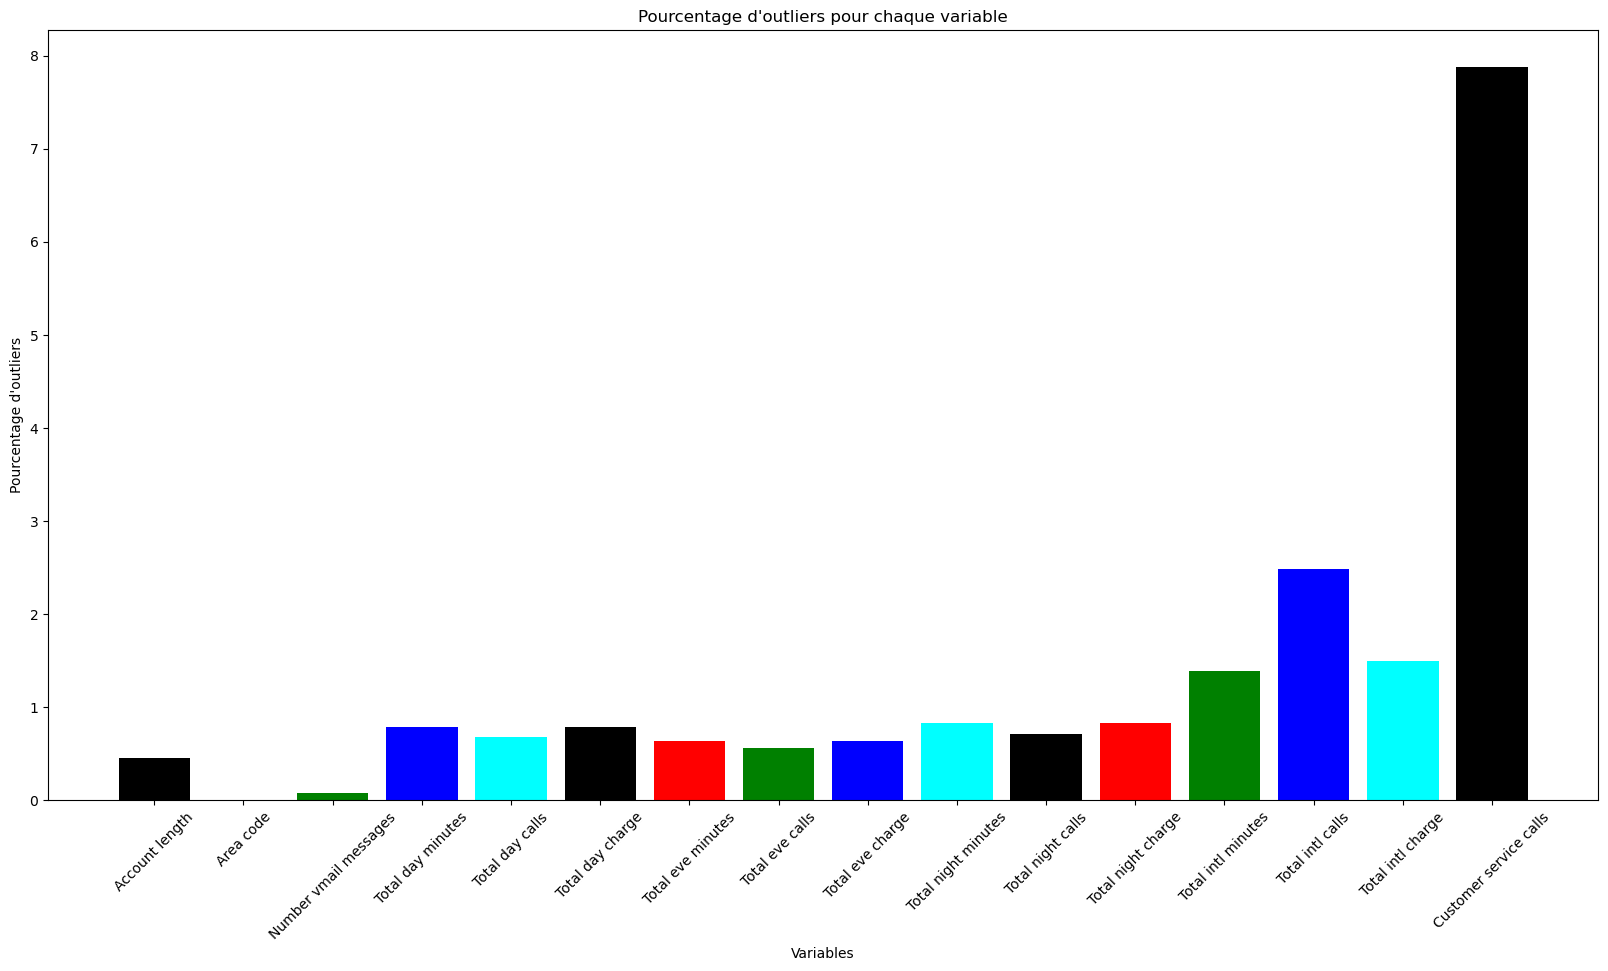

In [18]:
outliers_percentages = []
for col in numeric_vars:
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    upper_limit = q3 + 1.5 * iqr
    lower_limit = q1 - 1.5 * iqr
    outliers = df[(df[col] < lower_limit) | (df[col] > upper_limit)][col]
    percent = round((len(outliers)/len(df[col])) * 100,2)
    outliers_percentages.append(percent)
    print(f"Pourcentage d'outliers pour {col} : {percent}%")
    
num_var = numeric_vars.columns
plt.figure(figsize=(20,10))
plt.bar(num_var, outliers_percentages, color=['black', 'red', 'green', 'blue', 'cyan'])
plt.xticks(rotation=45)
plt.xlabel('Variables')
plt.ylabel('Pourcentage d\'outliers')
plt.title('Pourcentage d\'outliers pour chaque variable')
plt.show()

La variable "Customer service calls" présente le pourcentage le plus élevé de valeurs aberrantes (7,88%), mais cela reste tolérable. Par conséquent, ces données peuvent être traitées sans qu'ils soient modifiés pour une utilisation ultérieure.

In [19]:
def plot_piechart(df, var, target, labels, title):
    fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(20, 15))
    for i, ax in enumerate(axs.flatten()):
        grouped_dataset = df.groupby(target)[var[i]].sum()
        ax.pie(grouped_dataset, labels=labels, autopct='%1.2f%%')
        ax.set_title(f"{var[i]} by {target}", color="red")
    plt.show()

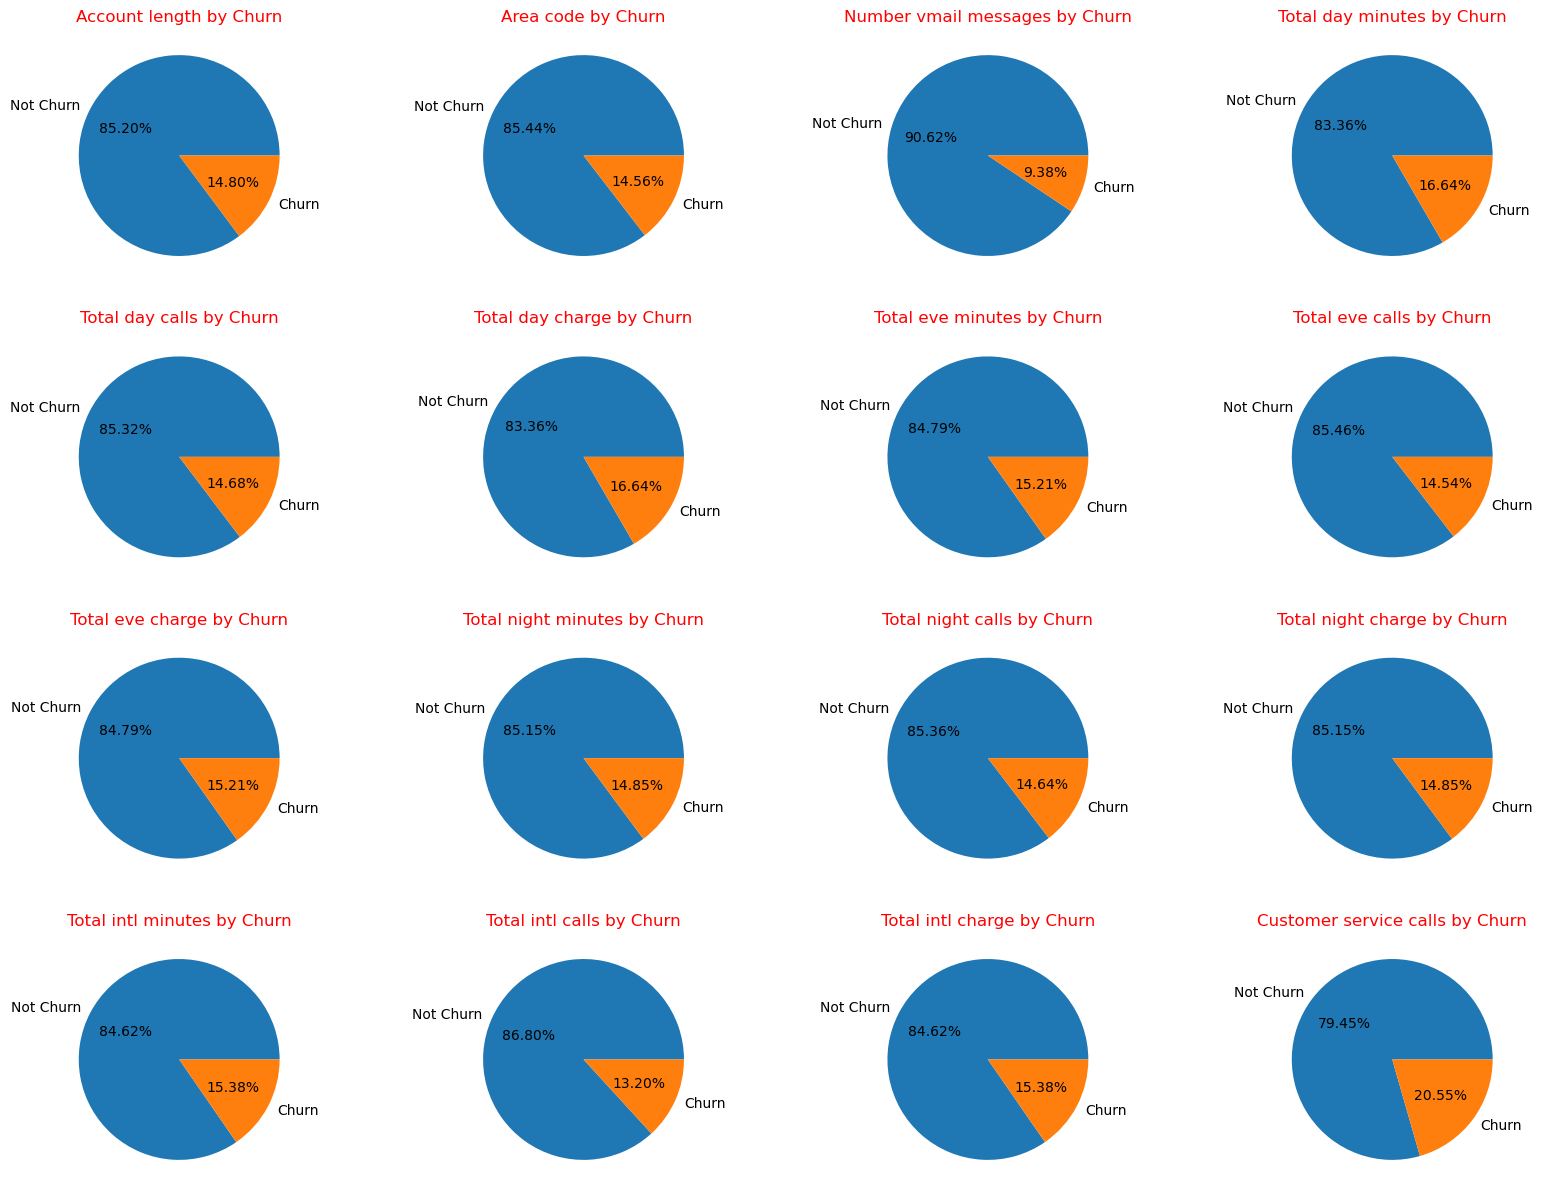

In [20]:
var = list(numeric_vars)
target = 'Churn'
labels = ['Not Churn', 'Churn']
title = []
plot_piechart(df, var, target, labels, title)

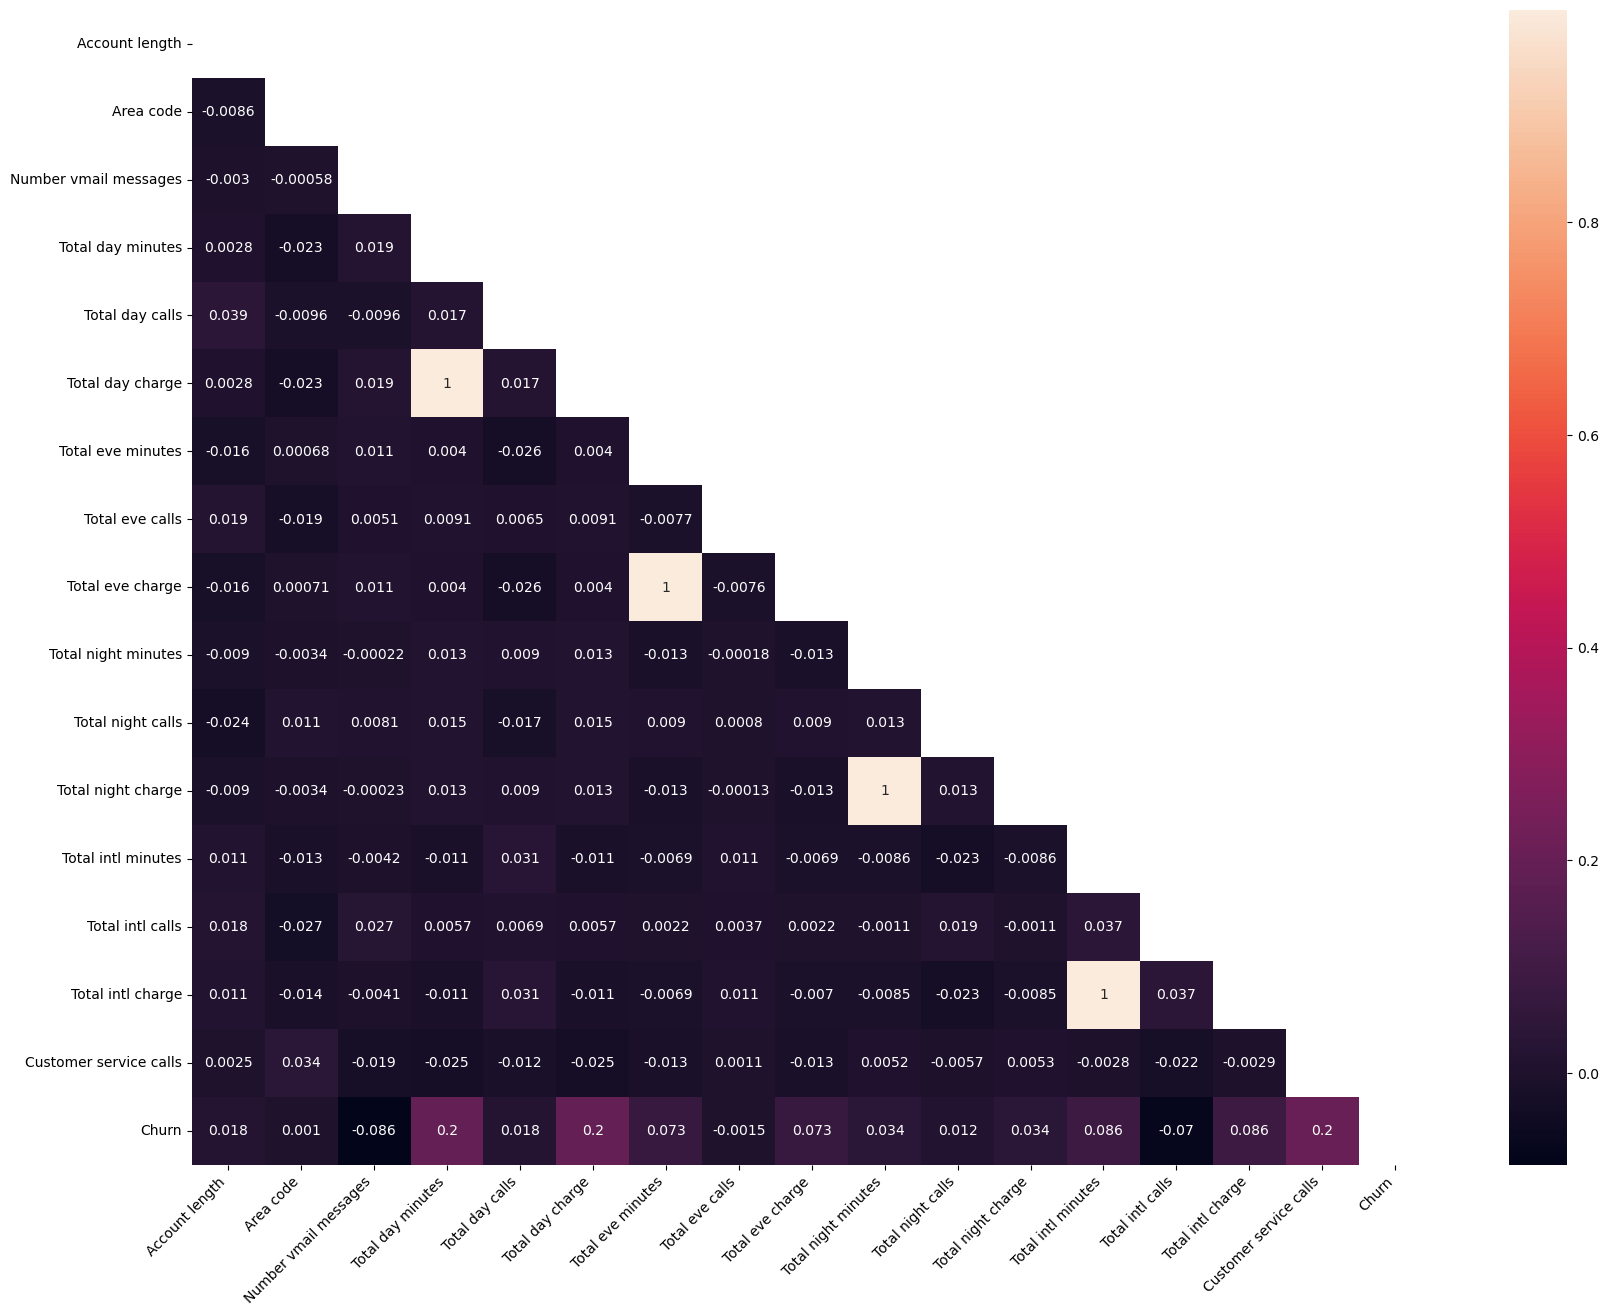

In [25]:
# Corrélation linéaire entre les variables 

df_corr = df.corr()
mask = np.triu(np.ones_like(df_corr,dtype=bool))
plt.figure(figsize=(20,15))
sns.heatmap(df_corr, mask=mask, annot=True)
plt.xticks(rotation=45, ha='right')
plt.show()

On remarque qu'il y'a des variables fortement corrélées entre eux et qu'ils doivent être supprimés par la suite pour éviter les problèmes de colinéarité car cela peut rendre les coefficients estimés pour chaque variable instables ou peu fiables, car la présence de deux variables corrélées peut les rendre redondantes et donc moins utiles pour la modélisation.

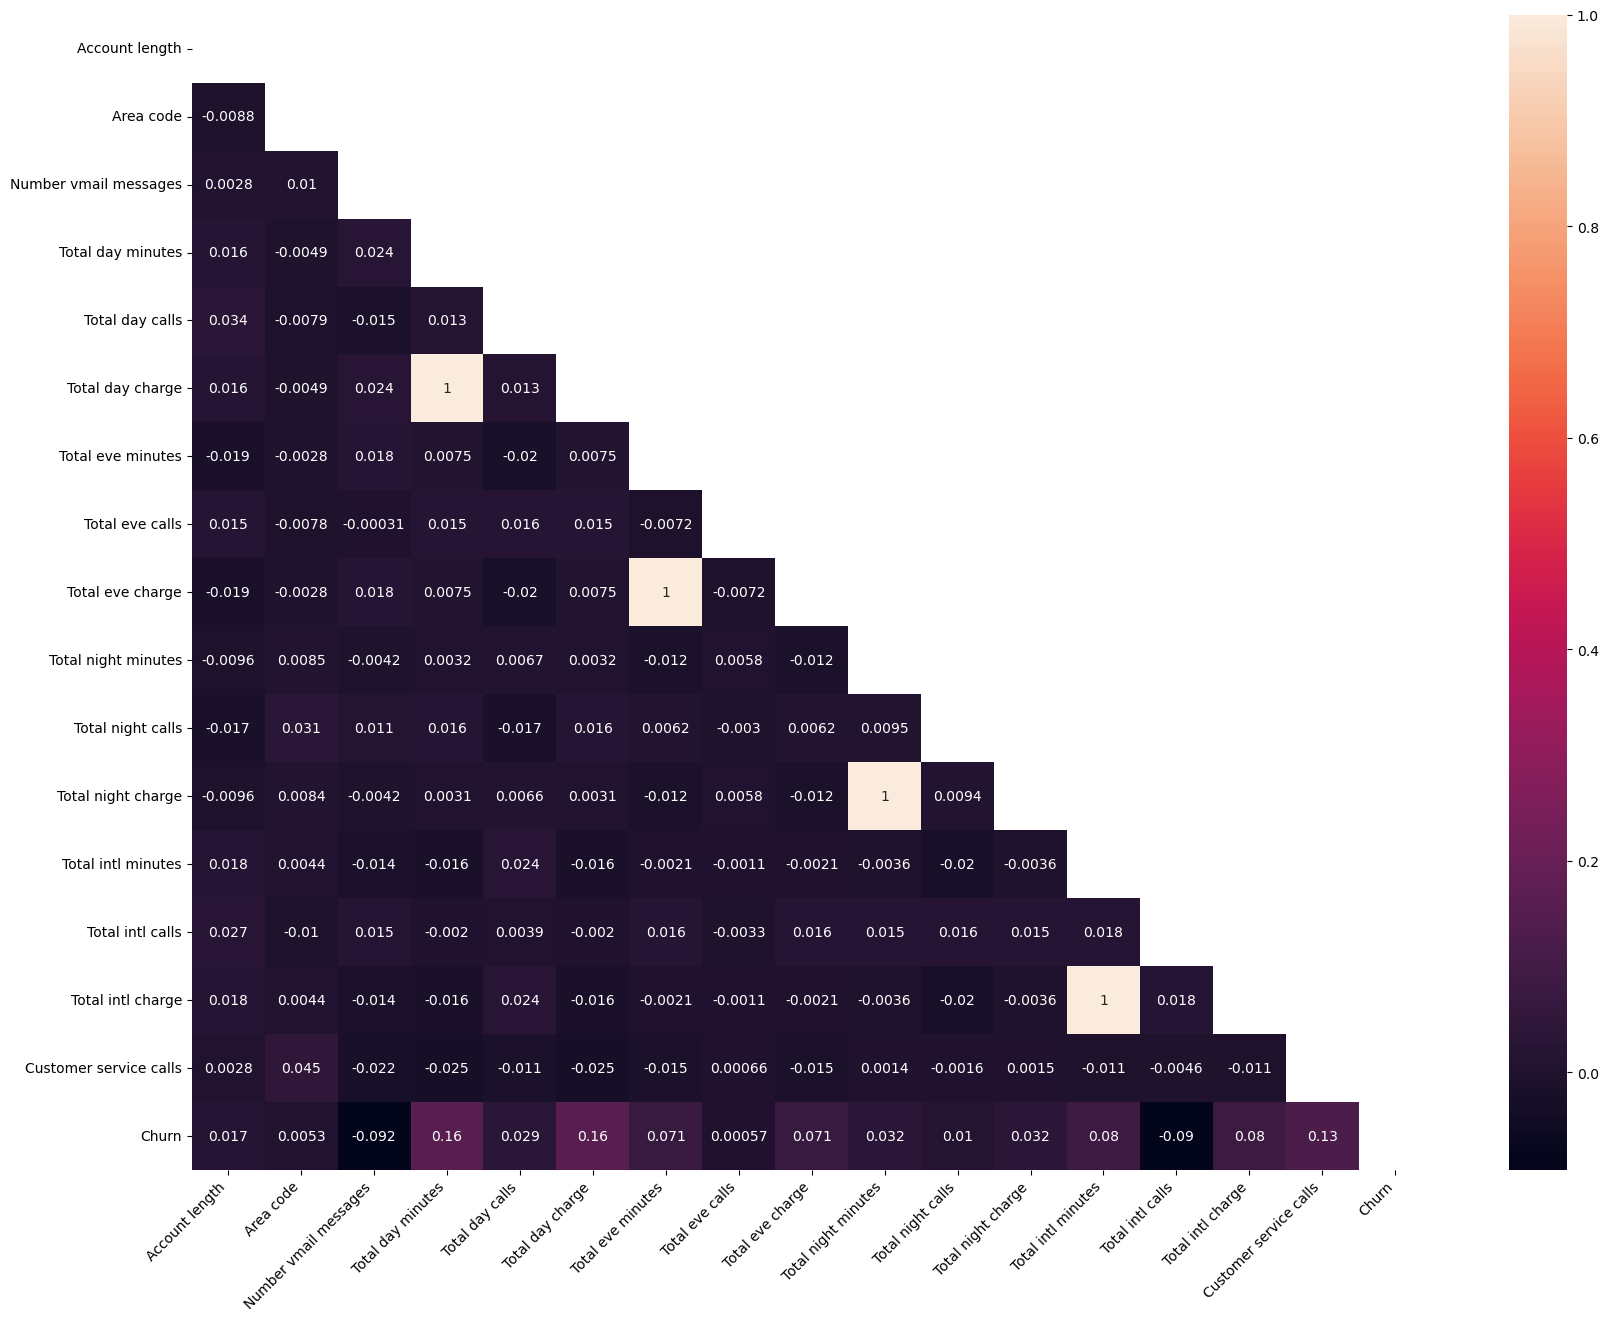

In [24]:
# corrélation non linéaire 

df_corr_nl = df.corr(method="spearman")
mask = np.triu(np.ones_like(df_corr_nl, dtype=bool))
plt.figure(figsize=(20,15))
sns.heatmap(df_corr_nl, mask=mask, annot=True)
plt.xticks(rotation=45, ha='right')
plt.show()

In [27]:
dfm = df.copy()

In [42]:
# effectuer une transformation LabelEncoder sur la variable 'Churn'
le = LabelEncoder()
dfm['Churn'] = le.fit_transform(dfm['Churn'])

Xm = dfm.drop('Churn', axis=1)
ym = dfm['Churn']

# Diviser les données : 80% pour l'entrainement et 20% pour le test 
Xm_train, Xm_test, ym_train, ym_test = train_test_split(Xm, ym, test_size=0.2, stratify=ym, random_state=42)
dfm.head()

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,KS,128,415,No,Yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,0
1,OH,107,415,No,Yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,0
2,NJ,137,415,No,No,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,0
3,OH,84,408,Yes,No,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,0
4,OK,75,415,Yes,No,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,0


In [43]:
categ_varsm = list(dfm.select_dtypes(include=['object', 'category']))
numeric_varsm = ['Account length',
 'Area code',
 'Number vmail messages',
 'Total day minutes',
 'Total day calls',
 'Total eve minutes',
 'Total eve calls',
 'Total night minutes',
 'Total night calls',
 'Total intl minutes',
 'Total intl calls',
 'Customer service calls']

# Création du pipeline pour la transformation StandardScaler() sur les données numériques
num_transformerm = Pipeline(steps=[('scaler', StandardScaler())])

# Création du pipeline pour la transformation OridnalEncoder() sur les données catégorielles
ord_transformerm = Pipeline([
    ('ord', OrdinalEncoder())
])

# l'application de ces transformations on utilisant ColumnTransformer
preprocessorm = ColumnTransformer(
    transformers=[
        ('num', num_transformerm, numeric_varsm),
        ('cat', ord_transformerm, categ_varsm),
    ])

In [44]:
#fonction pour évaluer les performances des modèles choisis

def test_models(preprocessor, models):

    pipe = Pipeline([('preprocessor', preprocessor),
                    ('model', None)])
    
    for name, model in models.items():
        pipe.set_params(model=model)
        pipe.fit(Xm_train, ym_train)
        ym_pred_train = pipe.predict(Xm_train)
        ym_pred_test = pipe.predict(Xm_test)
        print(f'-------{name} Metrics:---------\n')
        print(f'Matrice de confusion Test: ')
        print(f'{confusion_matrix(ym_test, ym_pred_test)}\n')
        print(f'Classification report Test : ')
        print(f'{classification_report(ym_test, ym_pred_test)}')

In [45]:
#Choix de différents modèles
models = {
    'Logistic Regression': LogisticRegression(),
    'KNN': KNeighborsClassifier(),
    'Random Forest': RandomForestClassifier(),
    'XGBoost': XGBClassifier()
}

test_models(preprocessorm, models)

-------Logistic Regression Metrics:---------

Matrice de confusion Test: 
[[434  22]
 [ 65  13]]

Classification report Test : 
              precision    recall  f1-score   support

           0       0.87      0.95      0.91       456
           1       0.37      0.17      0.23        78

    accuracy                           0.84       534
   macro avg       0.62      0.56      0.57       534
weighted avg       0.80      0.84      0.81       534

-------KNN Metrics:---------

Matrice de confusion Test: 
[[450   6]
 [ 68  10]]

Classification report Test : 
              precision    recall  f1-score   support

           0       0.87      0.99      0.92       456
           1       0.62      0.13      0.21        78

    accuracy                           0.86       534
   macro avg       0.75      0.56      0.57       534
weighted avg       0.83      0.86      0.82       534

-------Random Forest Metrics:---------

Matrice de confusion Test: 
[[454   2]
 [ 34  44]]

Classification

L'analyse révèle que les modèles LogisticRegression et KNN présentent des performances insuffisantes en termes de Recall et de f1_score, qui peuvent être attribuées au déséquilibre des classes.

Le modèle RandomForest a affiché des performances inférieures à XGBoost, tout en surclassant nettement les deux autres modèles.

Bien que le modèle XGBClassifier ait produit des performances solides, il convient d'explorer des moyens d'améliorer davantage ses résultats.

In [49]:
ratio = float(np.sum(ym_train == 0)) / np.sum(ym_train==1)

#choix des paramètres permettant d'équilibrer les deux classes de la variable "Churn"
models1 = {
    'Logistic Regression': LogisticRegression(class_weight='balanced'),
    'KNN': KNeighborsClassifier(),
    'Random Forest': RandomForestClassifier(max_samples=0.5),
    'XGBoost': XGBClassifier(scale_pos_weight=ratio)
}

test_models(preprocessorm, models1)

-------Logistic Regression Metrics:---------

Matrice de confusion Test: 
[[350 106]
 [ 29  49]]

Classification report Test : 
              precision    recall  f1-score   support

           0       0.92      0.77      0.84       456
           1       0.32      0.63      0.42        78

    accuracy                           0.75       534
   macro avg       0.62      0.70      0.63       534
weighted avg       0.83      0.75      0.78       534

-------KNN Metrics:---------

Matrice de confusion Test: 
[[450   6]
 [ 68  10]]

Classification report Test : 
              precision    recall  f1-score   support

           0       0.87      0.99      0.92       456
           1       0.62      0.13      0.21        78

    accuracy                           0.86       534
   macro avg       0.75      0.56      0.57       534
weighted avg       0.83      0.86      0.82       534

-------Random Forest Metrics:---------

Matrice de confusion Test: 
[[456   0]
 [ 35  43]]

Classification

On remarque que le modèle Logistic Regression a monté en performances en termes de Recall et f1_score alors le paramètre (class_weight='balanced') a une influence signifcative sur la classe minoritaire 

In [57]:
smote = SMOTE(random_state=42)

preprocessorm1 = ColumnTransformer(transformers=[
    ('num', num_transformerm, numeric_varsm),
    ('cat', ord_transformerm, categ_varsm)
])

In [58]:
def test_smote(preprocessor, smote, models):

    pipe = Pipeline([('preprocessor', preprocessor),
                     ('smote', smote),
                     ('model', None)])
    
    for name, model in models.items():
        pipe.set_params(model=model)
        pipe.fit(Xm_train, ym_train)
        ym_pred_train = pipe.predict(Xm_train)
        ym_pred_test = pipe.predict(Xm_test)
        print(f'-------{name} Metrics:---------\n')
        print(f'Matrice de confusion Test: ')
        print(f'{confusion_matrix(ym_test, ym_pred_test)}\n')
        print(f'Classification report Test : ')
        print(f'{classification_report(ym_test, ym_pred_test)}')

In [59]:
test_smote(preprocessorm, smote, models1)

-------Logistic Regression Metrics:---------

Matrice de confusion Test: 
[[351 105]
 [ 27  51]]

Classification report Test : 
              precision    recall  f1-score   support

           0       0.93      0.77      0.84       456
           1       0.33      0.65      0.44        78

    accuracy                           0.75       534
   macro avg       0.63      0.71      0.64       534
weighted avg       0.84      0.75      0.78       534

-------KNN Metrics:---------

Matrice de confusion Test: 
[[339 117]
 [ 39  39]]

Classification report Test : 
              precision    recall  f1-score   support

           0       0.90      0.74      0.81       456
           1       0.25      0.50      0.33        78

    accuracy                           0.71       534
   macro avg       0.57      0.62      0.57       534
weighted avg       0.80      0.71      0.74       534

-------Random Forest Metrics:---------

Matrice de confusion Test: 
[[429  27]
 [ 20  58]]

Classification

En utilisant SMOTE en remarque que tous les modèles ont monté en performances 

In [50]:
df1 = df.copy()
df2 = df.copy()

In [51]:
df1['Churn'] = le.fit_transform(df1['Churn'])
df2['Churn'] = le.fit_transform(df1['Churn'])

# Supprimer les variables fortément corrélées vues précédemment
df1.drop(['Total eve charge', 'Total day charge', 'Total night charge', 'Total intl charge'], axis=1, inplace=True)
df2.drop(['Total eve charge', 'Total day charge', 'Total night charge', 'Total intl charge'], axis=1, inplace=True)

In [52]:
# en se basant sur les kde_plot par rapport à la variable cible "Churn" on a convertit ces données numériques en catégorielle

df2['Account length'] = pd.cut(df2['Account length'], bins=[0, 100, 125, df['Account length'].max()], labels=['[0:100]', '[100:125]', '[>125]'])
df2['Total day minutes'] = pd.cut(df2['Total day minutes'], bins=[-10 , 250, 400], labels=['[0:250]', '[>250]'])
df2['Total eve minutes'] = pd.cut(df2['Total eve minutes'], bins=[-10, 250, 450], labels=['[0:250]', '[>250]'])
df2['Total intl minutes'] = pd.cut(df2['Total intl minutes'], bins=[-5, 12, 30], labels=['[0:12]', '[>12]'])
df2['Total intl calls'] = pd.cut(df2['Total intl calls'], bins=[-1, 4, 30], labels=['[0:4]', '[>4]'])
df2['Customer service calls'] = pd.cut(df2['Customer service calls'], bins=[-2, 3, 12], labels=['[0:3]', '[>3]'])

In [85]:
categ_vars1 = list(df1.select_dtypes(include=['object', 'category']))
numeric_vars1 = ['Account length',
 'Area code',
 'Number vmail messages',
 'Total day minutes',
 'Total day calls',
 'Total eve minutes',
 'Total eve calls',
 'Total night minutes',
 'Total night calls',
 'Total intl minutes',
 'Total intl calls',
 'Customer service calls']

categ_vars2 = list(df2.select_dtypes(include=['object', 'category']))
numeric_vars2 = ['Area code',
 'Number vmail messages',
 'Total day calls',
 'Total eve calls',
 'Total night minutes',
 'Total night calls']

X = df1.drop('Churn', axis = 1)
y = df1['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

data = {
    "X_train": X_train,
    "X_test": X_test,
    "y_train": y_train,
    "y_test": y_test
}


X1 = df2.drop('Churn', axis = 1)
y1 = df2['Churn']

X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2,stratify=y1, random_state=42)

data1 = {
    "X1_train": X1_train,
    "X1_test": X1_test,
    "y1_train": y1_train,
    "y1_test": y1_test
}

numerical_transformer = Pipeline(steps=[
    ('standard', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    #('ordinal', OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=np.nan))
    ('ordinal', OrdinalEncoder())
])

preprocessor = {
    'xgb': ColumnTransformer(transformers=[('num', numerical_transformer, numeric_vars1),('cat', categorical_transformer, categ_vars1)]),
    'lr':  ColumnTransformer(transformers=[('num', numerical_transformer, numeric_vars2),('cat', categorical_transformer, categ_vars2)]),
    'rf': ColumnTransformer(transformers=[('num', numerical_transformer, numeric_vars1),('cat', categorical_transformer, categ_vars1)]),
    'knn': ColumnTransformer(transformers=[('num', numerical_transformer, numeric_vars1),('cat', categorical_transformer, categ_vars1)])
}


Nous avons utilisé deux dictionnaires distincts pour notre analyse. Le premier, nommé "data", contient les données de test et d'entraînement pour le jeu de données, suite à une suppression des variables présentant une forte corrélation. Le second dictionnaire, nommé "data1", contient également les données de test et d'entraînement pour le jeu de données après avoir effectué une suppression des variables présentant une forte corrélation et ainsi nous avons procédé à une transformation des variables numériques en variables catégorielles, basée sur les graphiques de densité (kde_plot) en rapport avec la variable cible "Churn".

In [81]:
pipeline_rf = Pipeline(steps=[
    ('preprocessor', preprocessor['rf']),
    ('smote', SMOTE()),
    ('model', RandomForestClassifier())
])

pipeline_rf.fit(X_train, y_train)
y_rf = pipeline_rf.predict(X_test)
print(classification_report(y_test, y_rf))

              precision    recall  f1-score   support

           0       0.96      0.95      0.95       456
           1       0.73      0.74      0.74        78

    accuracy                           0.92       534
   macro avg       0.85      0.85      0.85       534
weighted avg       0.92      0.92      0.92       534



In [89]:
pipeline_knn = Pipeline(steps=[
    ('preprocessor', preprocessor['knn']),
    ('smote', SMOTE()),
    ('model', KNeighborsClassifier())
])

pipeline_knn.fit(X_train, y_train)
y_knn = pipeline_knn.predict(X_test)
print(classification_report(y_test, y_knn))

              precision    recall  f1-score   support

           0       0.90      0.77      0.83       456
           1       0.27      0.49      0.34        78

    accuracy                           0.73       534
   macro avg       0.58      0.63      0.59       534
weighted avg       0.81      0.73      0.76       534



In [141]:
pipeline_xgb = Pipeline(steps=[
    ('preprocessor', preprocessor['xgb']),
    #('smote', SMOTE()),
    ('model', XGBClassifier(objective='binary:logistic'))
])

pipeline_xgb.fit(X_train, y_train)
y_xgb = pipeline_xgb.predict(X_test)
print(classification_report(y_test, y_xgb))

              precision    recall  f1-score   support

           0       0.96      0.99      0.98       456
           1       0.95      0.76      0.84        78

    accuracy                           0.96       534
   macro avg       0.96      0.87      0.91       534
weighted avg       0.96      0.96      0.96       534



In [131]:
pipeline_lr = Pipeline(steps=[
    ('preprocessor', preprocessor['lr']),
    #('smote', SMOTE()),
    ('model', LogisticRegression(solver='saga' , penalty='l1', max_iter=1000, class_weight='balanced', C=1.2067926406393288)),
])

pipeline_lr.fit(X1_train, y1_train)
y_lr = pipeline_lr.predict(X1_test)
print(classification_report(y1_test, y_lr))

              precision    recall  f1-score   support

           0       0.95      0.81      0.88       456
           1       0.41      0.77      0.54        78

    accuracy                           0.81       534
   macro avg       0.68      0.79      0.71       534
weighted avg       0.87      0.81      0.83       534



En utilisant GridSearchCV() : LogisticRegression(solver='saga' , penalty='l1', max_iter=1000, class_weight='balanced', C=1.2067926406393288) qui donnes les meilleures performances pour le modèle

# Analyse des résultats

Après évaluation des performances on chosiit XGBoost vu qu'il nous fournit de bonnes performances et Logistic Regression afin de traiter un modèle de régression pour la suite de notre programme

# LES FONCTIONS

In [142]:
pipe = {
    'xgb': pipeline_xgb,
    'lr': pipeline_lr
}

clf = CalibratedClassifierCV(pipeline_xgb)
scorer = make_scorer(recall_score)
param_grid = {'clf__method': ['isotonic', 'sigmoid']}
kf = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)
grid_search = GridSearchCV(
estimator=Pipeline([('clf', clf)]),
param_grid=param_grid,
cv=kf,
scoring = scorer
)
grid_search.fit(X_train, y_train)
for method, score in zip(param_grid['clf__method'], grid_search.cv_results_['mean_test_score']):
    print("Méthode de calibration: %s, recall_score: %0.4f" % (method, score))
        
best_method = grid_search.best_params_['clf__method']
    
print('\n')
print("La méthode de calibration la plus performante est: %s" % best_method)
print("\n")
    
final_pipeline = Pipeline([
    ('clf', CalibratedClassifierCV(pipe['xgb'], cv=kf, method=best_method))
                          ])
final_pipeline.fit(X_train, y_train)
y_cal = final_pipeline.predict(X_test)
y_pred = pipe['xgb'].predict(X_test)
    
y_cal_score = final_pipeline.predict_proba(X_test)[:, 1] 

Méthode de calibration: isotonic, recall_score: 0.7612
Méthode de calibration: sigmoid, recall_score: 0.7355


La méthode de calibration la plus performante est: isotonic




Nous avons procédé à une recherche de grille croisée (GridSearchCV) pour déterminer la méthode de calibrage la plus performante adaptée à notre cas, et il s'avère que la méthode isotonic a été sélectionnée.

In [143]:
def calib_xgb(X_train, X_test, y_train, y_test, y_score, model_name):
    print("scores de base : ")
    print(f"{classification_report(y_test, y_pred)} \n")
    print("scores après calibration")
    print(f"{classification_report(y_test, y_cal)} \n")
    fraction_of_positives, mean_predicted_value = calibration_curve(y_test, y_score, n_bins=10)
    plt.plot(mean_predicted_value, fraction_of_positives, "s-", label=model_name)
    
    fraction_of_positives, mean_predicted_value = calibration_curve(y_test, y_cal_score, n_bins=10)
    plt.plot(mean_predicted_value, fraction_of_positives, 's-', label='%s' % best_method)
    
    plt.plot([0, 1], [0, 1], '--', color='gray', label='Référence')
    plt.xlabel('Probabilité moyenne prédite')
    plt.ylabel('Fraction de positifs')
    plt.legend()
    plt.show()

In [144]:
y_len = np.zeros(len(y_test))

In [145]:
def rec_prec_cal(y_test):
    print("---------- Precision-Recall graphe---------- \n")   
    precision, recall, threshold = precision_recall_curve(
    y_test, y_cal_score)
    tst_prt = pd.DataFrame({
    "threshold": threshold,
    "recall": recall[1:],
    "precision": precision[1:]
    })
    tst_prt_melted = pd.melt(tst_prt, id_vars = ["threshold"],value_vars = ["recall", "precision"])
    sns.lineplot(x = "threshold", y = "value",hue = "variable", data = tst_prt_melted)
    optimal_proba_cutoff = sorted(list(zip(np.abs(precision - recall), threshold)), key=lambda i: i[0], reverse=False)[0][1]
    print(f"threshold d'intersection est : {optimal_proba_cutoff:.2f} \n")
    print(f'scores de base : ')
    print(f'{classification_report(y_test, y_pred)}\n')
    print(f'scores calibrés après modification de threshold: ')
    print(f'{classification_report(y_test, y_len)}')

In [146]:
def roc_auc(y_test, y_score, model_name):
    roc_auc = roc_auc_score(y_test, y_score)
    false_positive_rate, true_positive_rate, threshold = roc_curve(y_test, y_score)
    plt.figure(figsize=(20, 8))
    plt.plot(false_positive_rate, true_positive_rate, color='b', label='ROC curve (area = %0.3f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='r', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) for '+model_name)
    plt.legend(loc='lower right')
    plt.show()

In [147]:
scoring = ['accuracy', 'precision', 'recall', 'f1']
kf = StratifiedKFold(n_splits=3,random_state=42,shuffle=True)
def lear_curve(X, y, scoring, pipe, model_name):
    fig, axs = plt.subplots(nrows=len(scoring)//2, ncols=2, figsize=(20, 8))
    axs = axs.flatten()
    for i, metric in enumerate(scoring):
        train_sizes, train_scores, test_scores = learning_curve(estimator=pipe,
                                                                X=X,
                                                                y=y,
                                                                train_sizes=np.linspace(0.1, 1.0, 5),
                                                                cv=kf,
                                                                scoring=metric)
        train_scores_mean = np.mean(train_scores, axis=1)
        train_scores_std = np.std(train_scores, axis=1)
        test_scores_mean = np.mean(test_scores, axis=1)
        test_scores_std = np.std(test_scores, axis=1)

        axs[i].plot(train_sizes, train_scores_mean, label='train')
        axs[i].fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.2)
        axs[i].plot(train_sizes, test_scores_mean, label='test')
        axs[i].fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.2)
        axs[i].legend(loc='best')
        axs[i].set_title(metric+' '+model_name)
        axs[i].set_xlabel("Taille de l'échantillon d'entraînement")
        axs[i].set_ylabel("Score")

    plt.tight_layout()
    plt.show()

In [151]:
def models_aff(pipe, data_dict, model_type):
    if model_type == 'xgb':
        X_train = data_dict['X_train']
        X_test = data_dict['X_test']
        y_train = data_dict['y_train']
        y_test = data_dict['y_test']
        
    
        pipe.fit(X_train, y_train)
        y_pred = pipe.predict(X_test)
        y_score = pipe.predict_proba(X_test)[:, 1]
        model_name = 'XGBoost'
        roc_auc(y_test, y_score, model_name)
        y_len[y_cal_score >= 0.39 ] = 1.
        calib_xgb(X_train, X_test, y_train, y_test, y_score, model_name)
        print('\n')
        print('threshold choisi : 0.39')
        rec_prec_cal(y_test)
        lear_curve(X, y, scoring, pipeline_xgb, model_name)
    
    elif model_type == 'lr':
        X_train = data_dict['X1_train']
        X_test = data_dict['X1_test']
        y_train = data_dict['y1_train']
        y_test = data_dict['y1_test']

        pipe.fit(X_train, y_train)
        y_pred = pipe.predict(X_test)
        y_score = pipe.predict_proba(X_test)[:, 1]
        model_name = 'Logistic Regression'
        #rec_prec(y_test, y_score, y_pred)
        print(classification_report(y_pred, y_test))
        roc_auc(y_test, y_score, model_name) 
        lear_curve(X1, y1, scoring, pipeline_lr, model_name)
                
    else:
        print("Error: Model type not supported.")
        return  
    
    #rec_prec(y_test, y_score, y_pred)
    #roc_auc(y_test, y_score, model_name)
    #calibrate_curve(lr_pipeline, X_train, X_test, y_train, y_test, y_score, y_pred, model_name)   
    #calibrate_curve(xgb_pipeline, X_train, X_test, y_train, y_test, y_score, y_pred, model_name)
    #lear_curve(X1, y1, scoring, lr_pipeline, model_name)
    #lear_curve(X, y, scoring, xgb_pipeline, model_name)

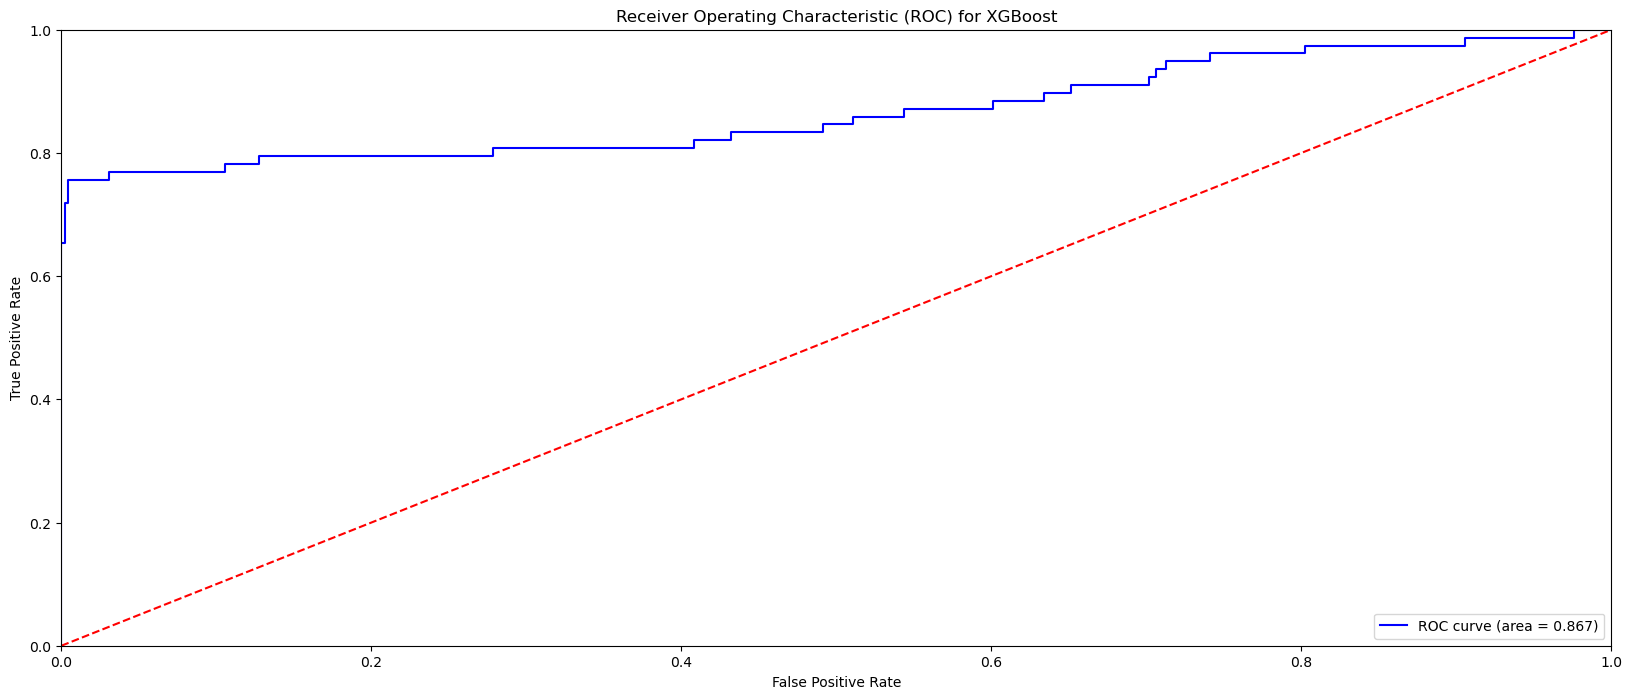

scores de base : 
              precision    recall  f1-score   support

           0       0.96      0.99      0.98       456
           1       0.95      0.76      0.84        78

    accuracy                           0.96       534
   macro avg       0.96      0.87      0.91       534
weighted avg       0.96      0.96      0.96       534
 

scores après calibration
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       456
           1       0.97      0.73      0.83        78

    accuracy                           0.96       534
   macro avg       0.96      0.86      0.90       534
weighted avg       0.96      0.96      0.95       534
 



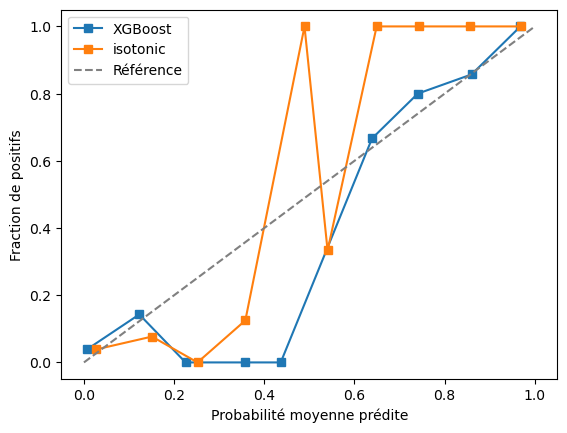



threshold choisi : 0.39
---------- Precision-Recall graphe---------- 

threshold d'intersection est : 0.23 

scores de base : 
              precision    recall  f1-score   support

           0       0.96      0.99      0.98       456
           1       0.95      0.76      0.84        78

    accuracy                           0.96       534
   macro avg       0.96      0.87      0.91       534
weighted avg       0.96      0.96      0.96       534


scores calibrés après modification de threshold: 
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       456
           1       0.97      0.77      0.86        78

    accuracy                           0.96       534
   macro avg       0.96      0.88      0.92       534
weighted avg       0.96      0.96      0.96       534



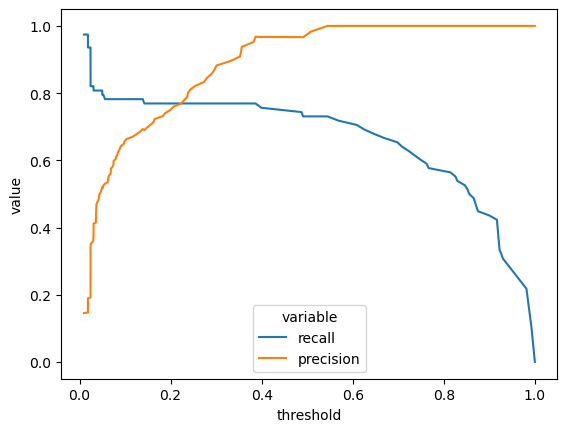

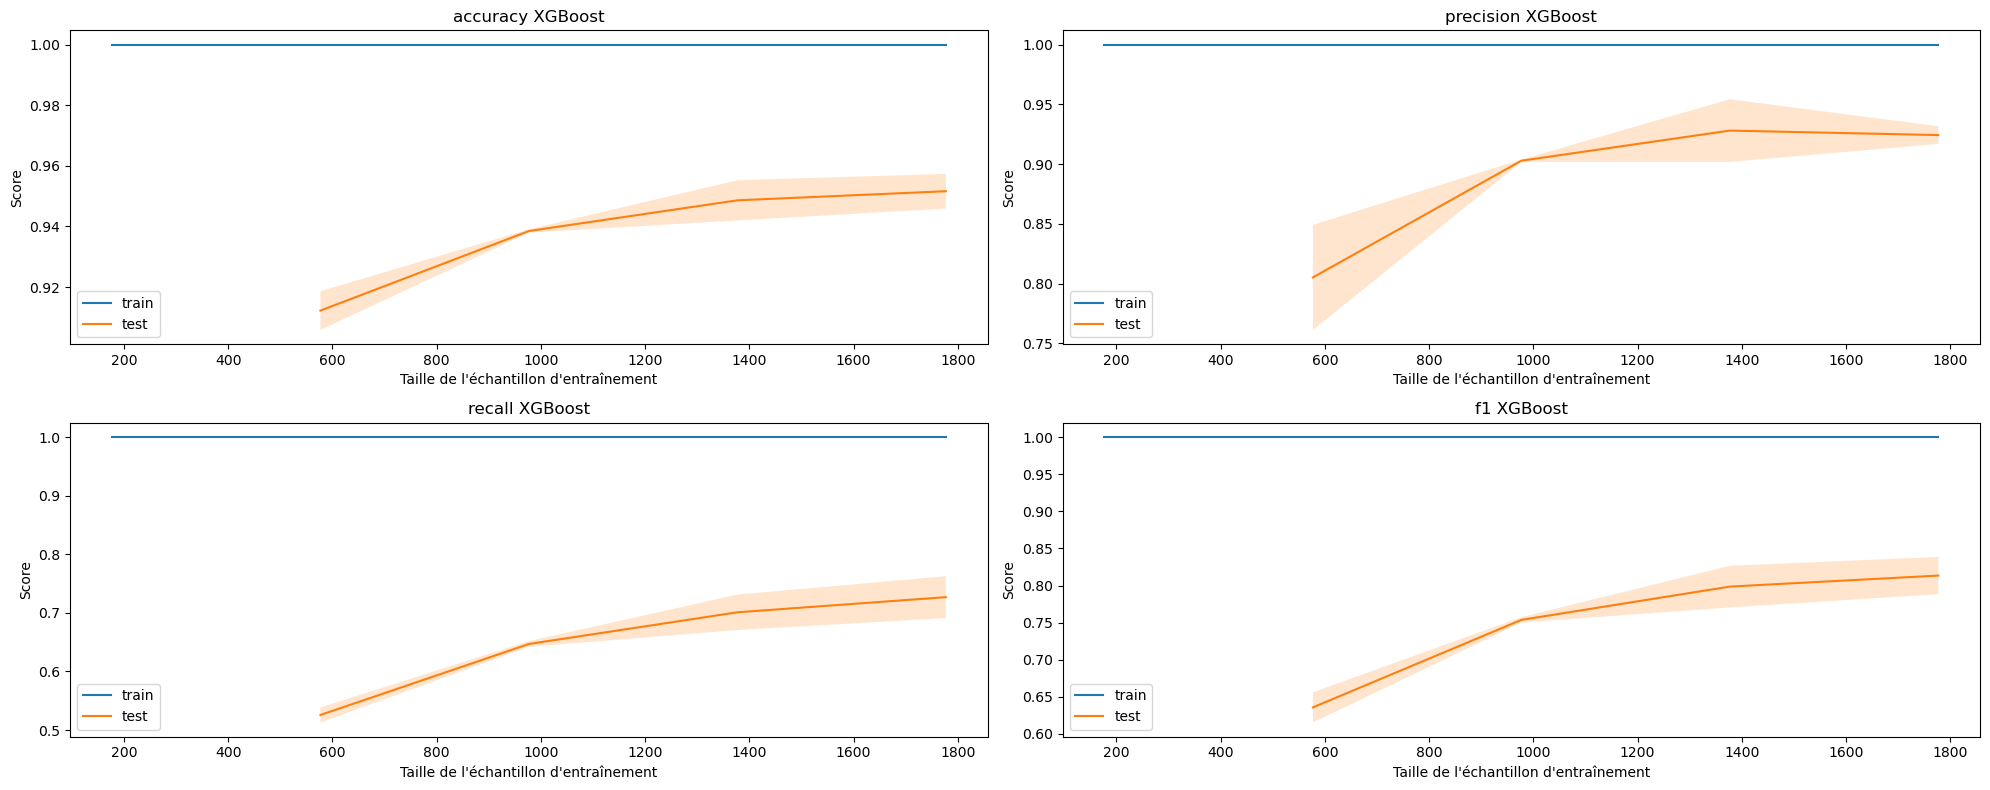

In [152]:
models_aff(pipeline_xgb, data, 'xgb')

 . On remarque que aprés la calibration isotonic du modèle XGBoost a monté en performances en termes de tous les métriques de classification report
 
 . En examinant les graphiques générés par la fonction LearningCurve(), on observe que le modèle présente une capacité de généralisation élevée pour les données d'entraînement, mais affiche également des performances très satisfaisantes sur les données de test.

              precision    recall  f1-score   support

           0       0.82      0.95      0.88       390
           1       0.77      0.42      0.54       144

    accuracy                           0.81       534
   macro avg       0.79      0.69      0.71       534
weighted avg       0.80      0.81      0.79       534



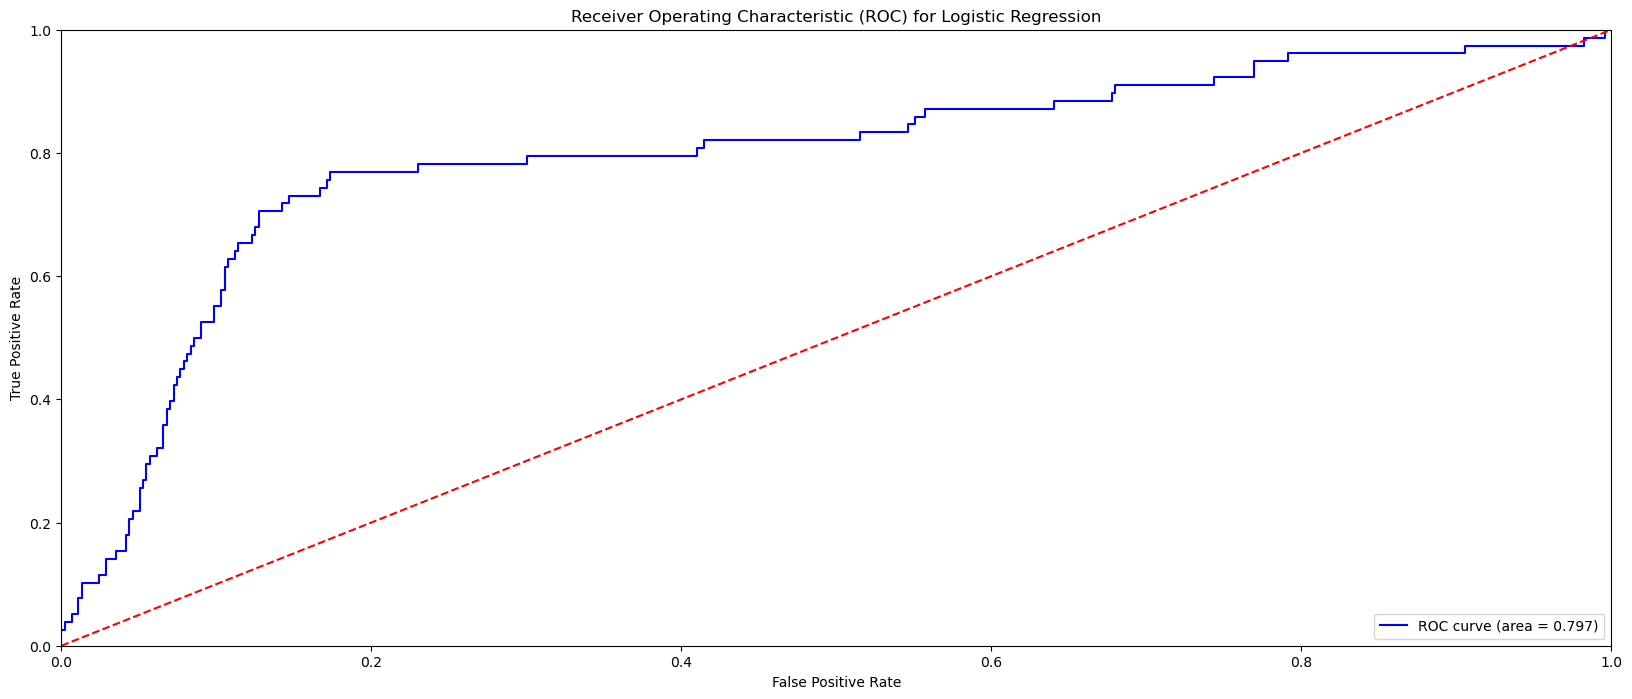

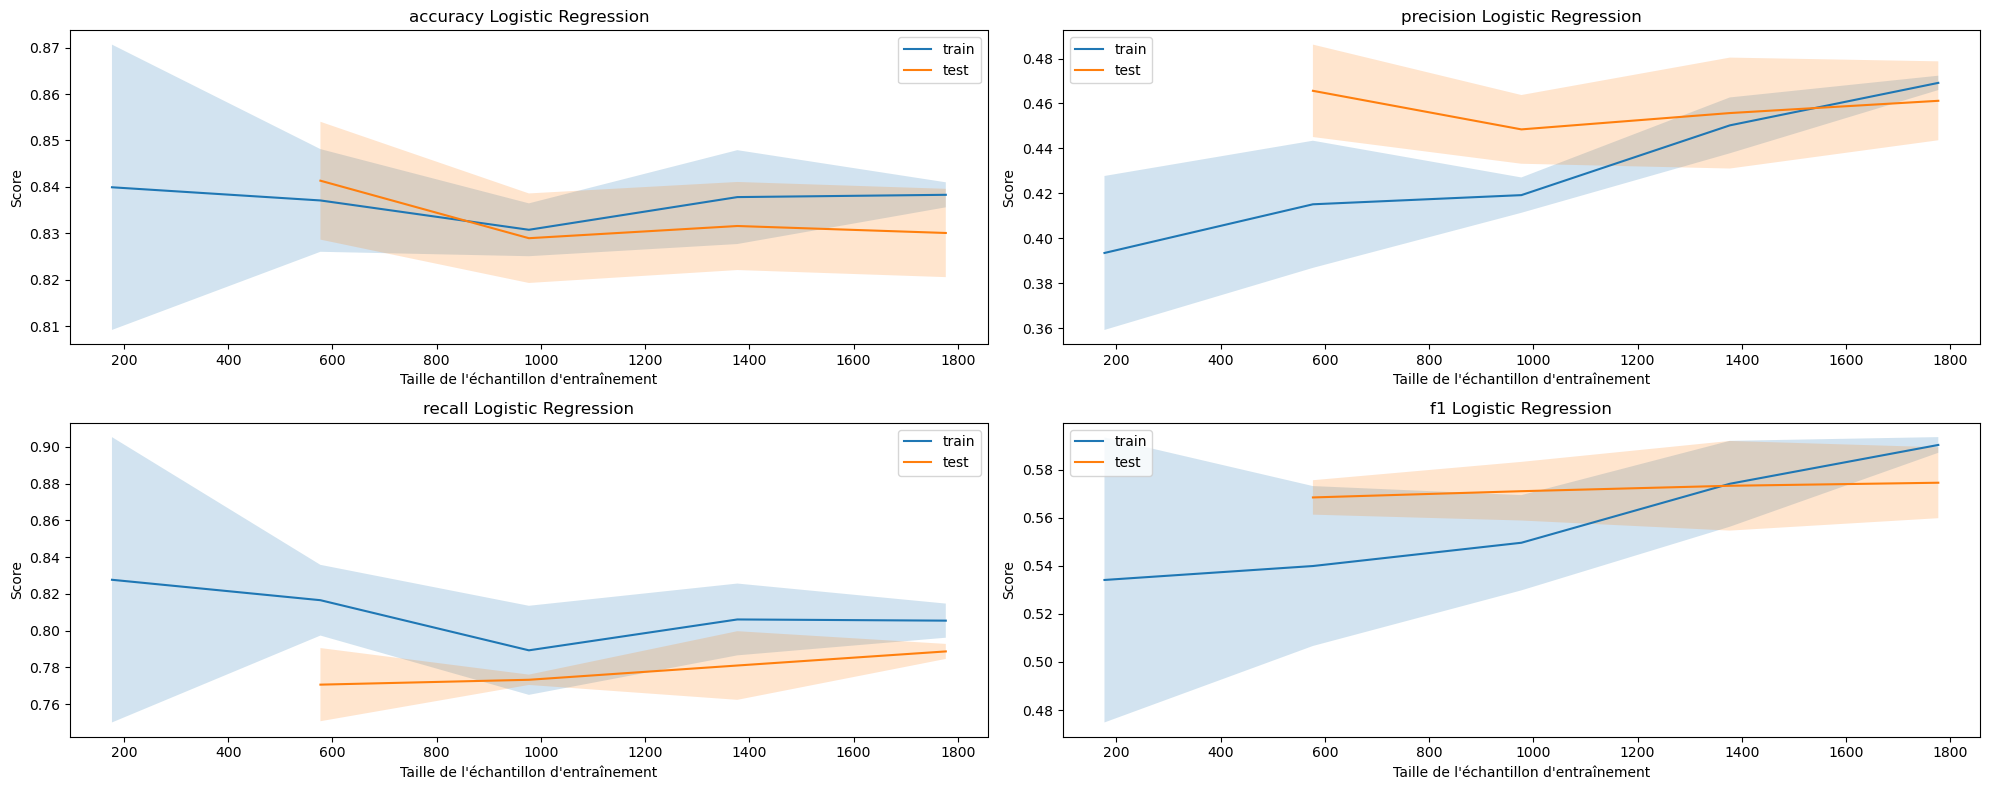

In [113]:
models_aff(pipeline_lr, data1, 'lr')

Il est observé que les courbes de la fonction LearningCurve() montrent une supériorité initiale des performances de test par rapport à celles d'entraînement. Cette observation peut être expliquée par la capacité de généralisation précoce du modèle LogisticRegression(), qui peut être attribuée à sa simplicité ainsi qu'à l'insuffisance de données d'entraînement.

In [114]:
importance_lr = pipeline_lr['model']
importance_xgb = pipeline_xgb['model']

In [115]:
def feature_importance():
    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(20, 12))
    #importance = pipeline_lr.steps[1][1].coef_[0]
    importance = pipeline_lr['model'].coef_[0]
    feat_importances = pd.Series(importance, index=X1_train.columns)
    top_feat_importances = feat_importances.nlargest(20)
    color_palette = sns.color_palette("Paired", len(top_feat_importances))
    top_feat_importances.plot(kind='barh', title='Feature Importance for Logistic Regression', color=color_palette)
    ax[1].set_xlabel('Importance')
    ax[1].invert_yaxis()
    ax[1].set_yticklabels(labels=top_feat_importances.index.tolist())

    feature_importances = importance_xgb.feature_importances_
    sorted_idx = feature_importances.argsort()
    sorted_features = [X_train.columns[i] for i in sorted_idx]
    ax[0].barh(sorted_features, feature_importances[sorted_idx], color=color_palette)
    ax[0].set_title('Feature Importance for XGBClassifier')
    ax[0].set_xlabel('Importance')

    plt.show()

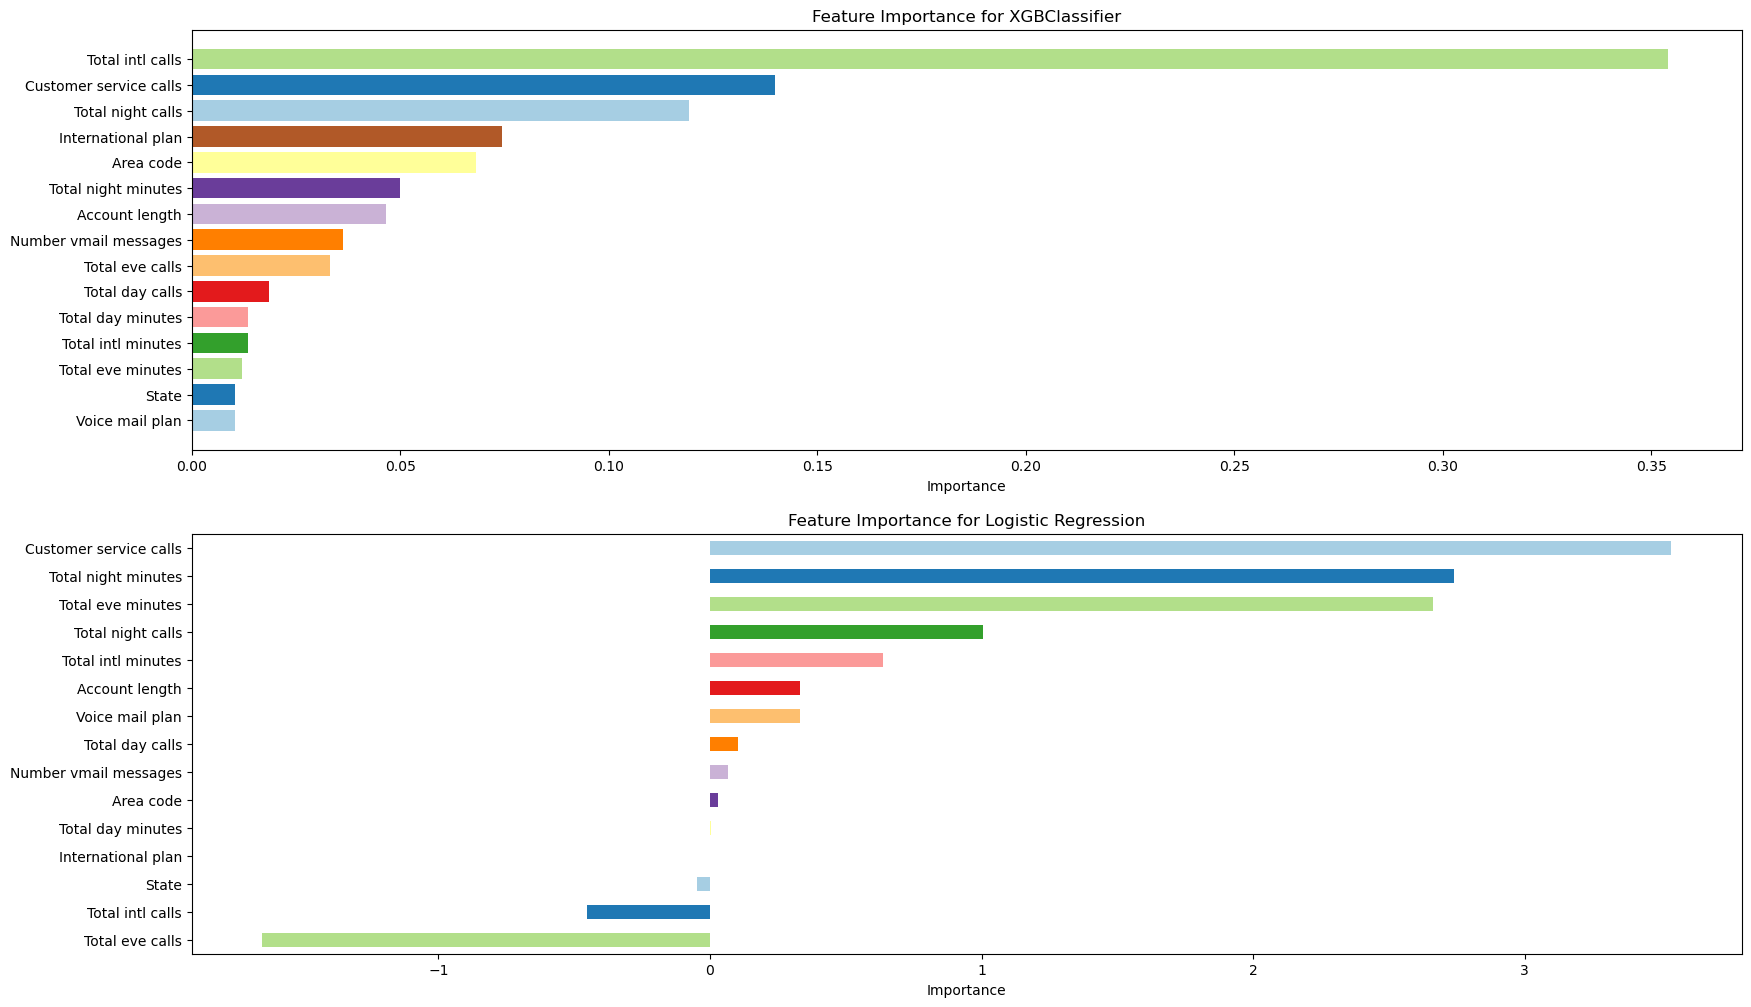

In [153]:
feature_importance()

In [154]:
X_test_enc = preprocessor['xgb'].transform(X_test)
X1_test_enc = preprocessor['lr'].transform(X1_test)

In [155]:
def permut_importance():
    fig, ax = plt.subplots(2, 1, figsize=(20,12))
    result = permutation_importance(importance_xgb, X_test_enc, y_test, n_repeats=10, random_state=42)
    importance = result.importances_mean
    sorted_idx = importance.argsort()
    features = X_test.columns
    color_palette = sns.color_palette("Paired", len(features))
    ax[0].barh(range(len(sorted_idx)), importance[sorted_idx], color=color_palette)
    ax[0].set_yticks(range(len(sorted_idx)), [features[i] for i in sorted_idx])
    ax[0].set_title("permutation importance for XGBoost")
    ax[0].set_xlabel('Permutation Importance')

    result1 = permutation_importance(importance_lr, X1_test_enc, y1_test, n_repeats=10, random_state=42)
    importance1 = result1.importances_mean
    sorted_idx1 = importance1.argsort()
    features1 = X1_test.columns
    ax[1].barh(range(len(sorted_idx1)), importance1[sorted_idx1], color=color_palette)
    ax[1].set_yticks(range(len(sorted_idx1)), [features1[i] for i in sorted_idx1])
    ax[1].set_title("permutation importance for Logistic regression")
    ax[1].set_xlabel('Permutation Importance')

    plt.show()

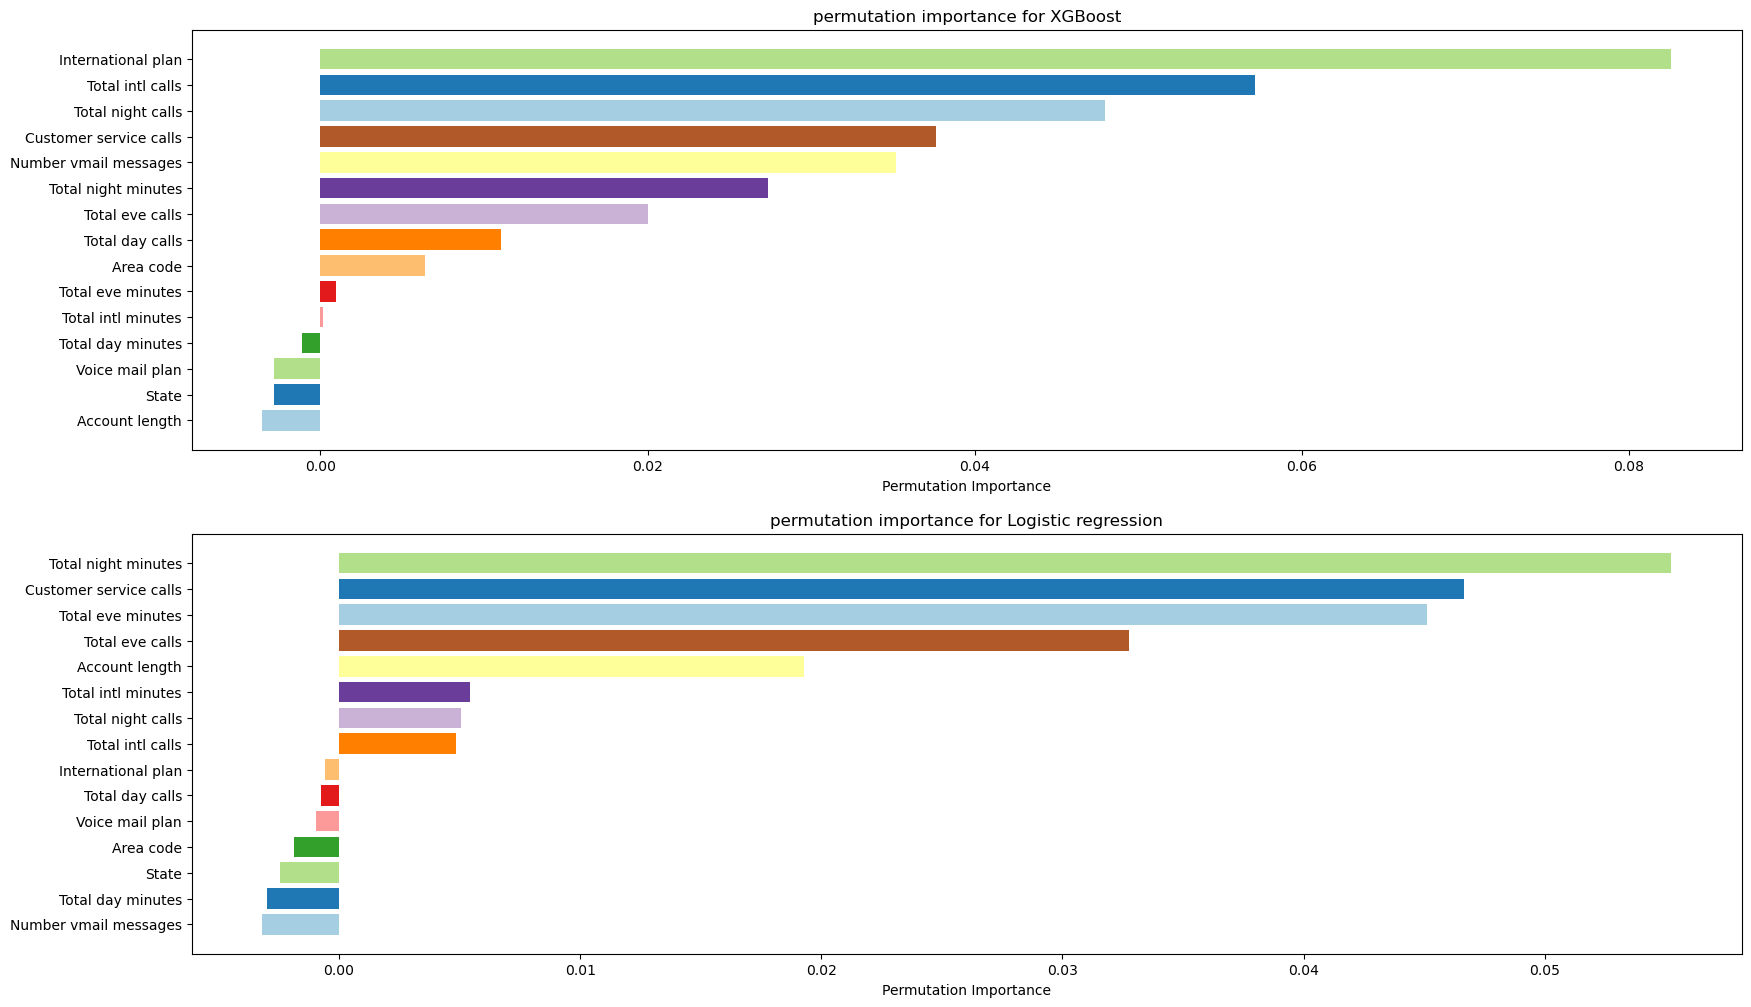

In [156]:
permut_importance()

In [157]:
X_train_transformed = preprocessor['xgb'].transform(X_train)
X_test_transformed = preprocessor['xgb'].transform(X_test)

X1_train_transformed = preprocessor['lr'].transform(X1_train)
X1_test_transformed = preprocessor['lr'].transform(X1_test)


explainer = shap.Explainer(pipeline_xgb['model'], X_train_transformed, feature_names=X_train.columns)

explainer1 = shap.Explainer(pipeline_lr['model'], X1_train_transformed, feature_names=X1_train.columns)

shap_values = {
    'xgb' : explainer(X_test_transformed),
    'lr' : explainer1(X1_test_transformed)
}

In [158]:
def shap_bar():
    plt.figure()
    shap.plots.bar(shap_values['xgb'], max_display=20, show = False)
    plt.gcf().set_size_inches(20,12)
    plt.title("shap bar for XGBoost") 

    plt.figure()
    shap.plots.bar(shap_values['lr'], max_display=20, show = False)
    plt.gcf().set_size_inches(20,12)
    plt.title("Shap bar for Logistic regression")
    plt.show()

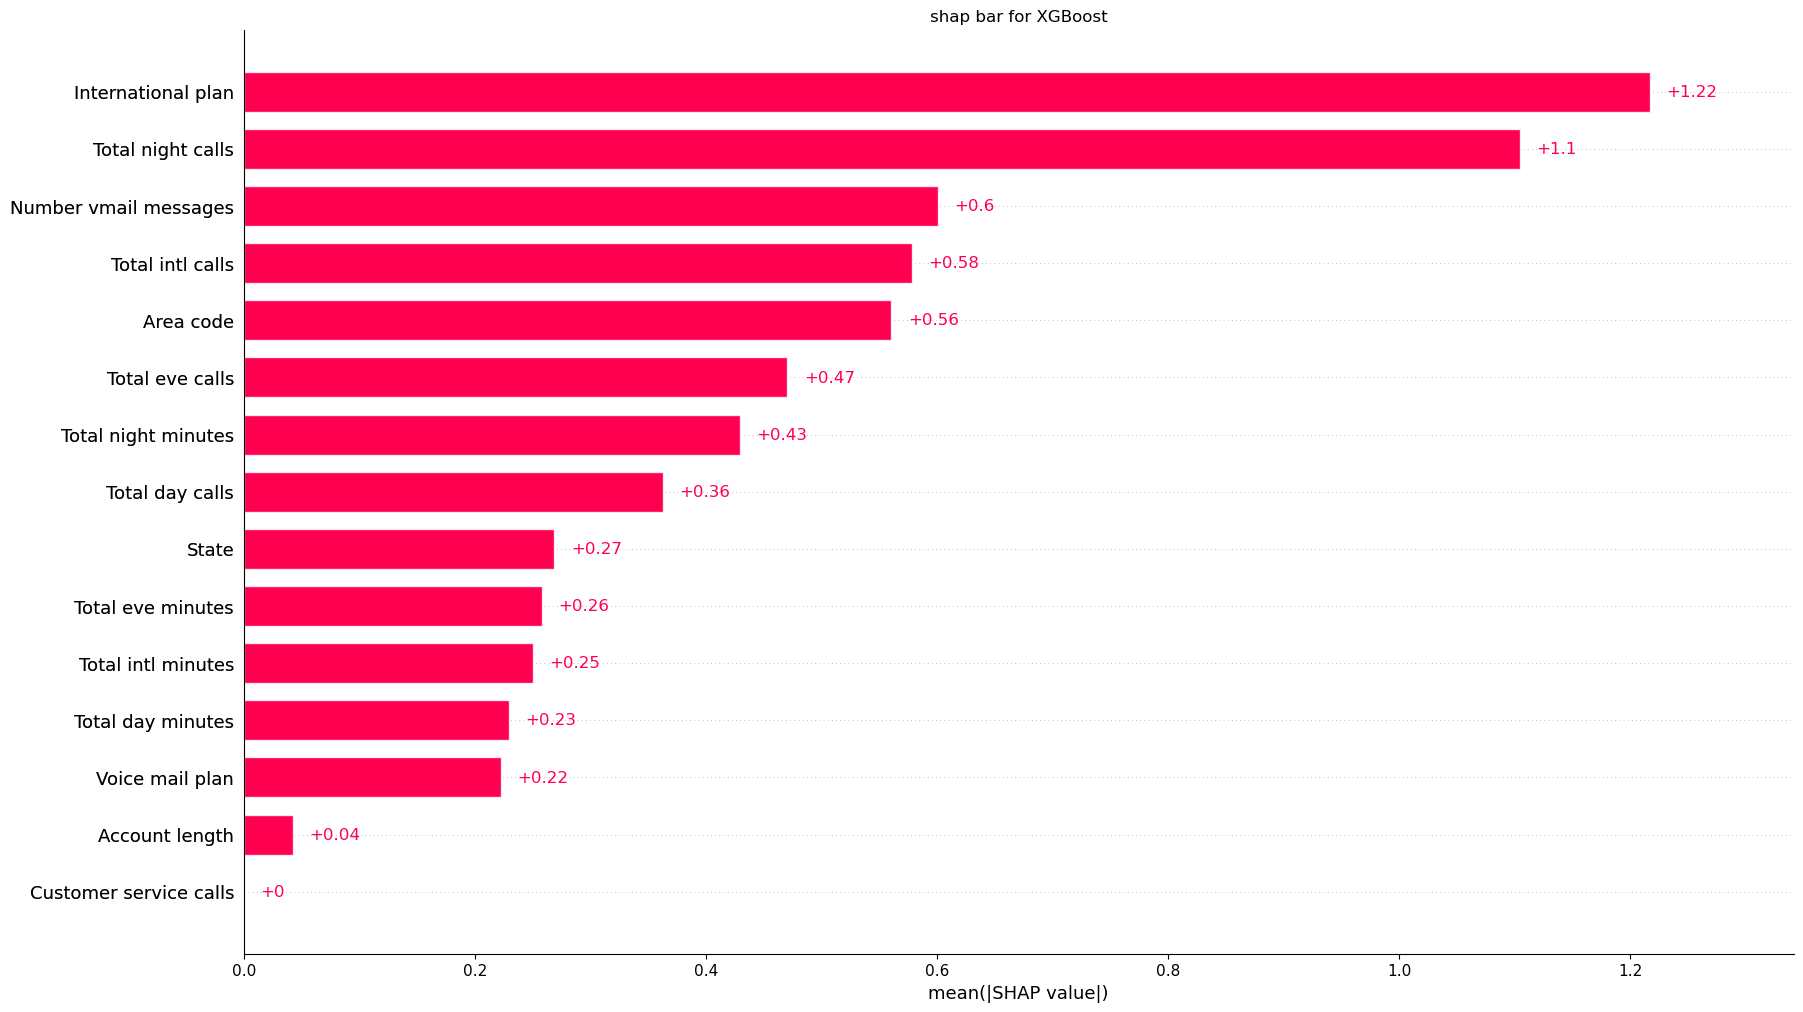

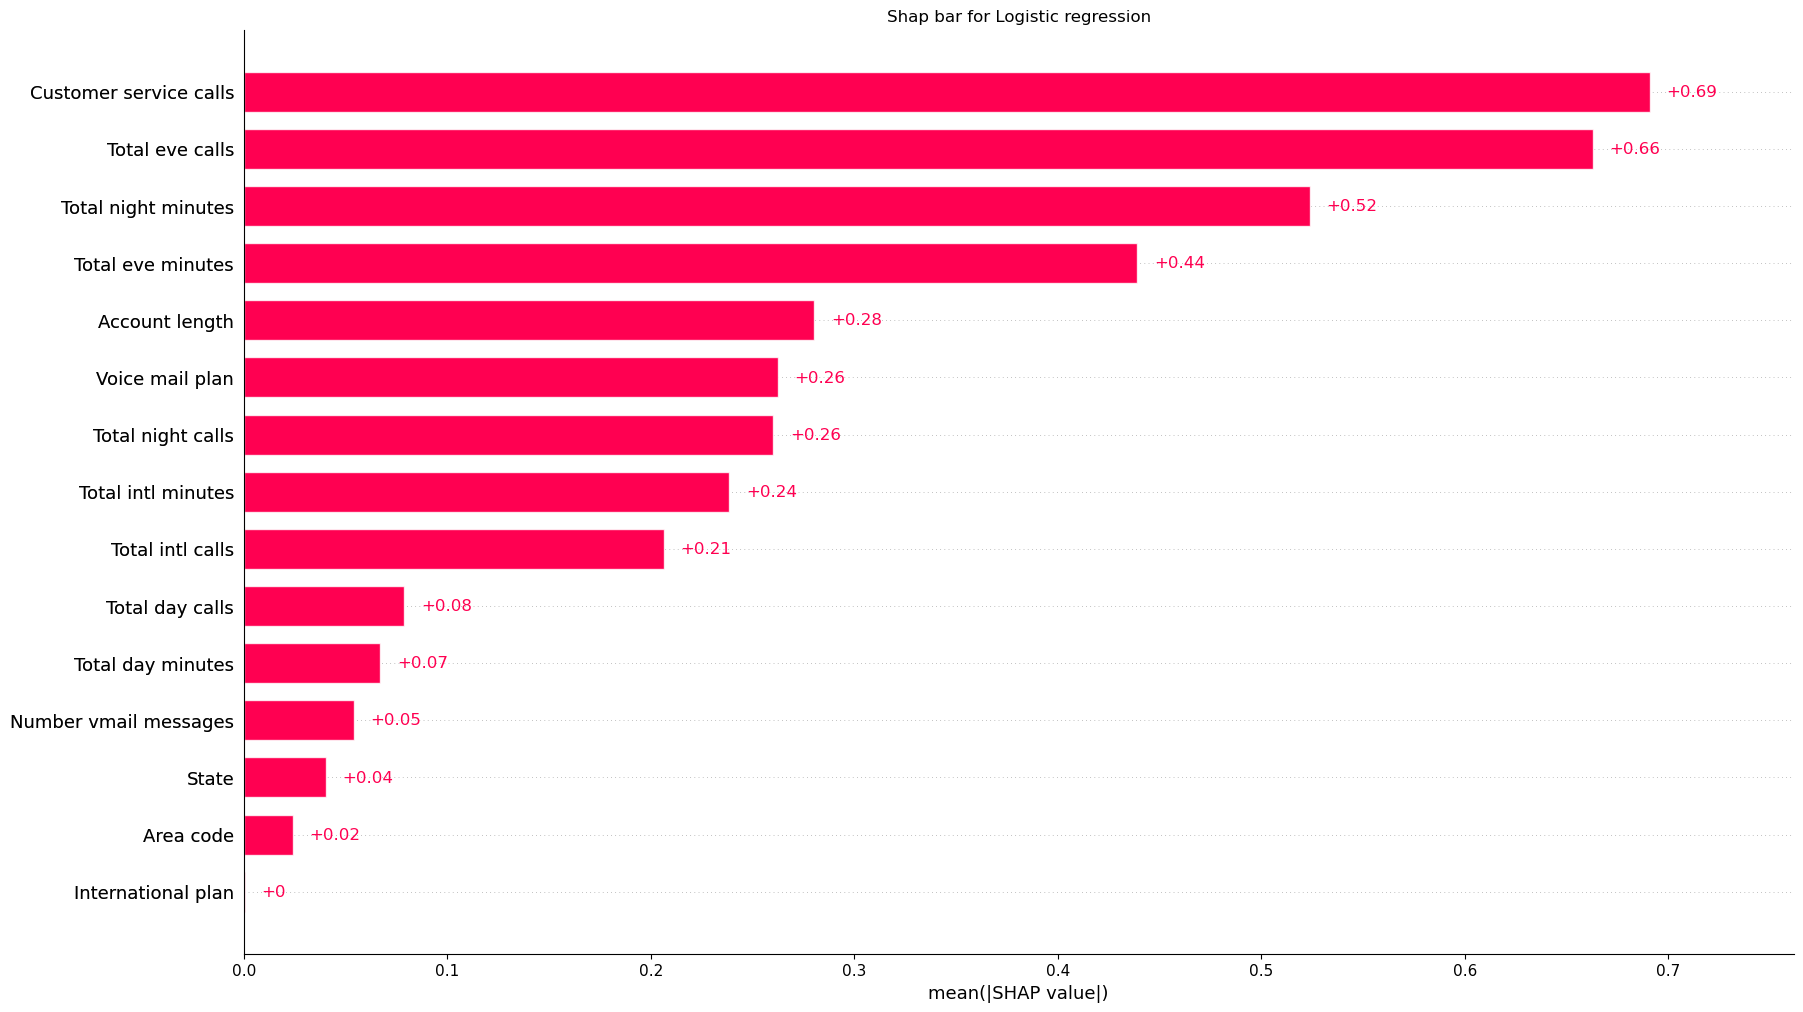

In [159]:
shap_bar()

Les valeurs SHAP moyennes absolues représentent en effet l'impact moyen absolu de chaque variable sur l'attrition des clients, indépendamment de la direction de l'impact.


In [160]:
def shap_beeswarm():
    plt.figure()
    shap.plots.beeswarm(shap_values['xgb'], max_display=20, show = False)
    plt.gcf().set_size_inches(15,11)
    plt.title("Shap beeswarm for XGBoost") 


    plt.figure()
    shap.plots.beeswarm(shap_values['lr'], max_display=20, show = False)
    plt.gcf().set_size_inches(15,11)
    plt.title("Shap beeswarm for Logistic regression")

    plt.show()

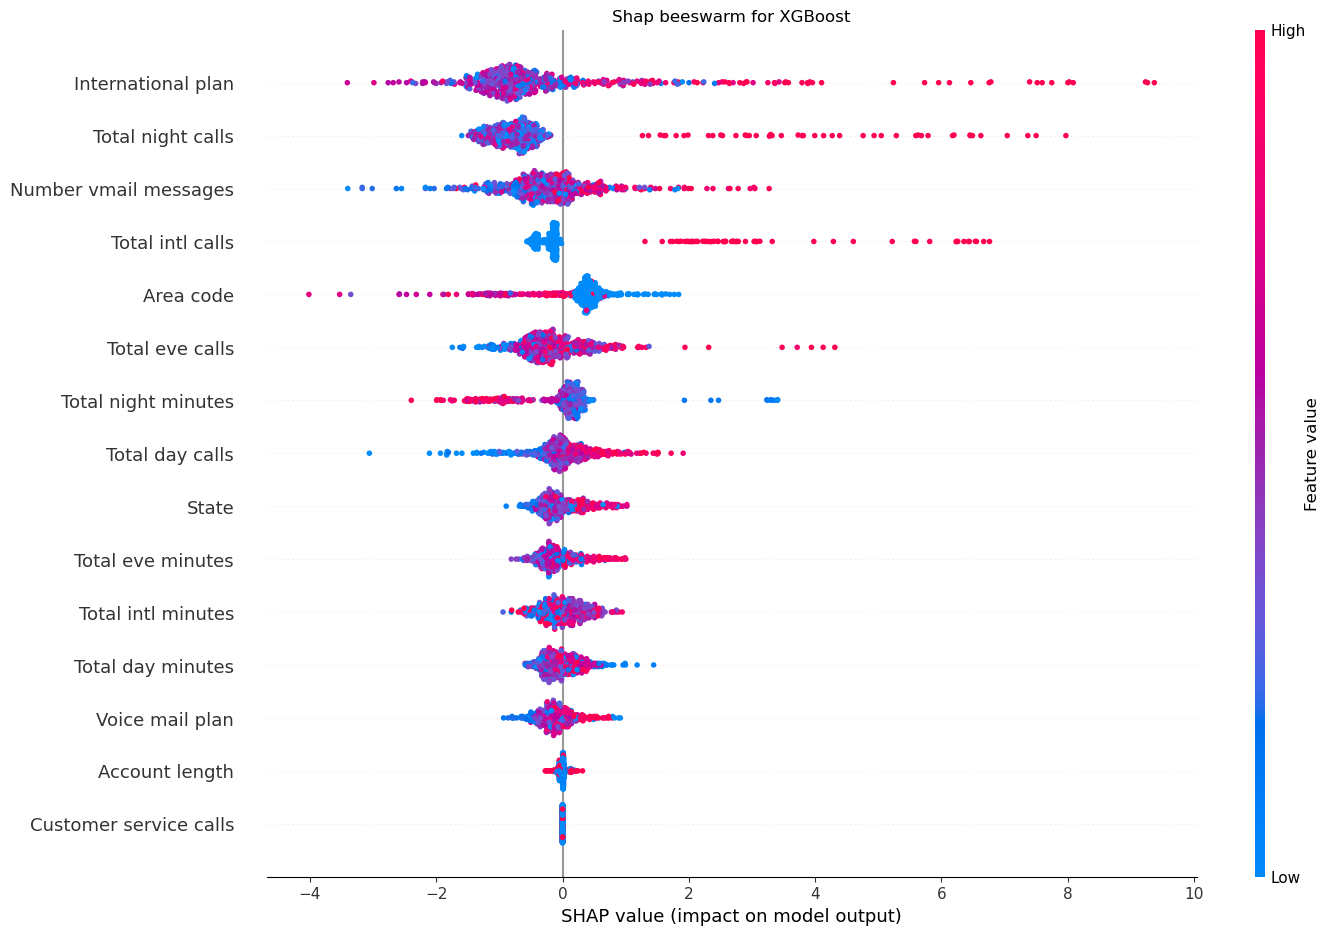

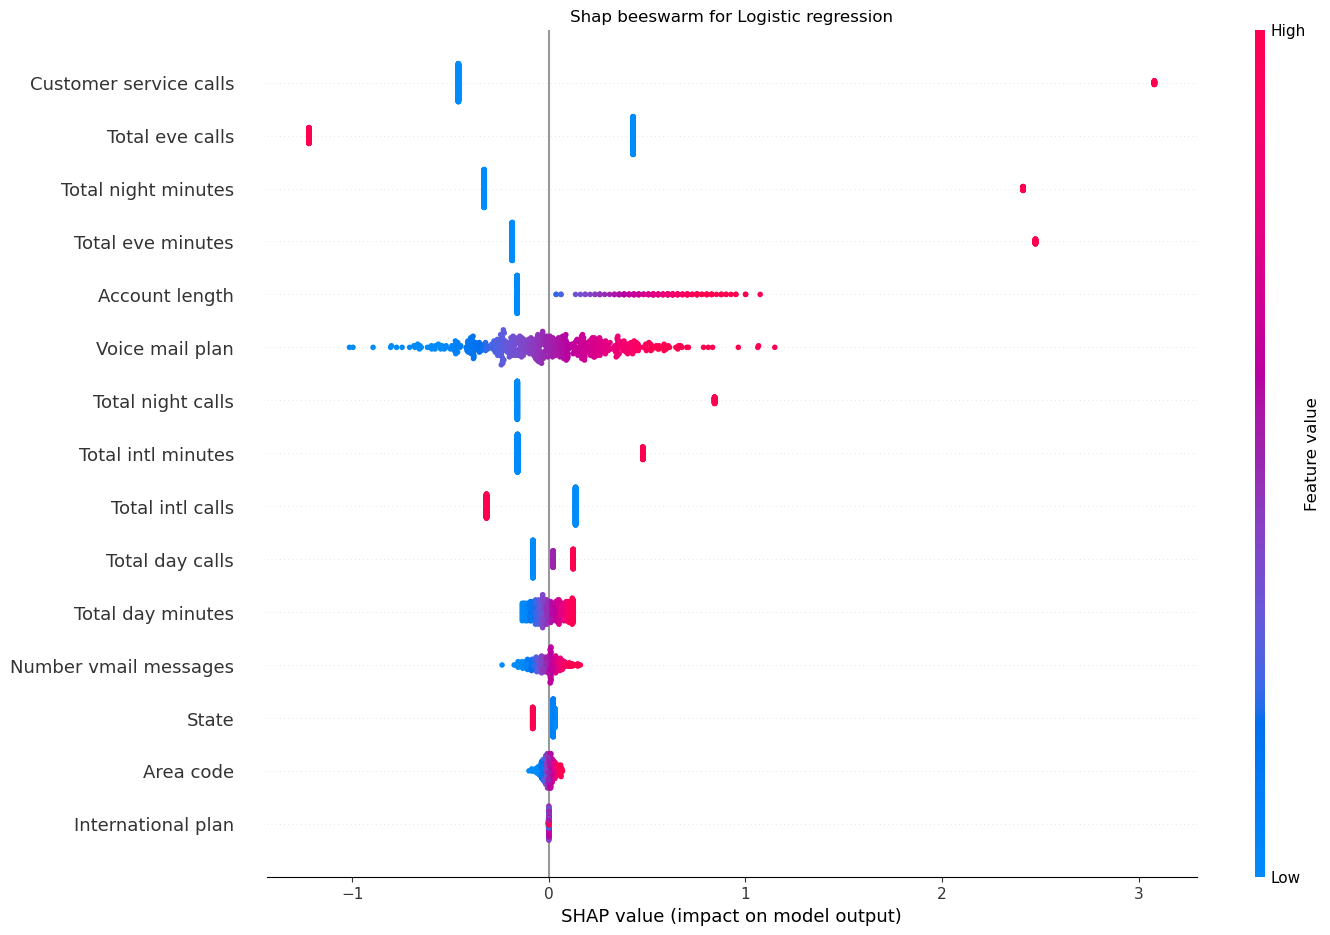

In [161]:
shap_beeswarm()

#  Commentaires : 

**XGBoost:**

les valeurs de "International plan" et "Total night calls" ont une forte contribution positive à la prédiction de la probabilité de churn , càd les clients qui ont des niveaux de consommation la nuit plus élevées et ont souscrit un plan international ont une probabilité de churn plus élevée.

Des valeurs faibles de "Number vmail messages" contribuent à une probabilité de churn aussi faible et les valeurs élevées ont une contribution positive à la prédiction de la probabilité de churn
 
la variable "Total intl calls" a une forte contribution positive à la prédiction de la probabilité de churn. Ainsi, les clients qui effectuent un grand nombre d'appels internationaux ont une probabilité de churn plus élevée que les clients qui effectuent un nombre plus faible d'appels internationaux.

Des valeurs élevées de "Area Code" ont une contribution négative à la prédiction de la probabilité de churn , càd les clients qui ont "Area code" élevé ont une probabilité de churn faible

des valeurs élevées de "Total night minutes" contribuent à une prédiction faible de la probabilité de churn

Des valeurs élevées "Total day calls" contribuent positivement à la prédiction de la probabilité de churn alors que des valeurs faibles contribuent à la prédiction de cette prédiction négativement.

**Logistic Regression:**

Plus les valeurs de "Customer service calls", "Total night minutes", "Total eve minutes", "Account length", "Voice mail plan", "Total night calls", "Total intl minutes" plus les probabilités de churn augmentent aussi .

Les valeurs élevées de "Total eve calls" et "Total intl calls" ont une contribution négative à la prédiction de la probabilité de churn .

In [162]:
feature = ['Customer service calls', 'Total eve calls', 'Total night minutes', 'Total eve minutes', 'Account length', 'Voice mail plan', 'Total night calls', 'Total intl minutes', 'Total intl calls', 'Total day calls', 'Total day minutes', 'Number vmail messages', 'State', 'Area code', 'International plan']

In [163]:
def shap_scatter_lr(feature, shap_values):
    for i in range(0, len(feature)-1, 2):
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,10))
        shap.plots.scatter(shap_values[:, feature[i]], ax=axes[0], show=False)
        shap.plots.scatter(shap_values[:, feature[i+1]], ax=axes[1], show=False)
        plt.show()

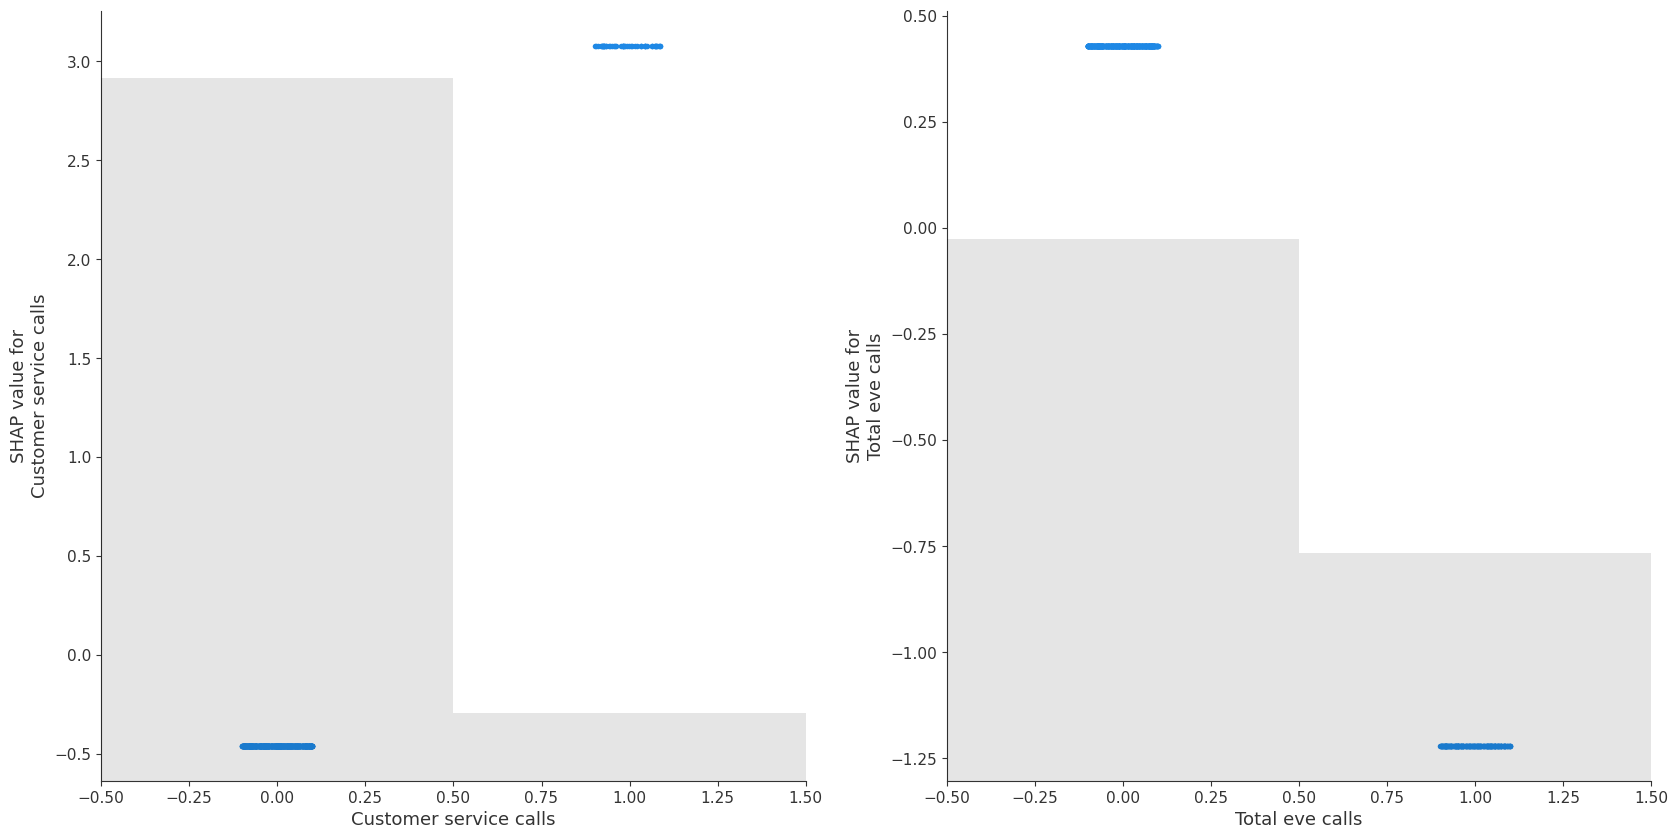

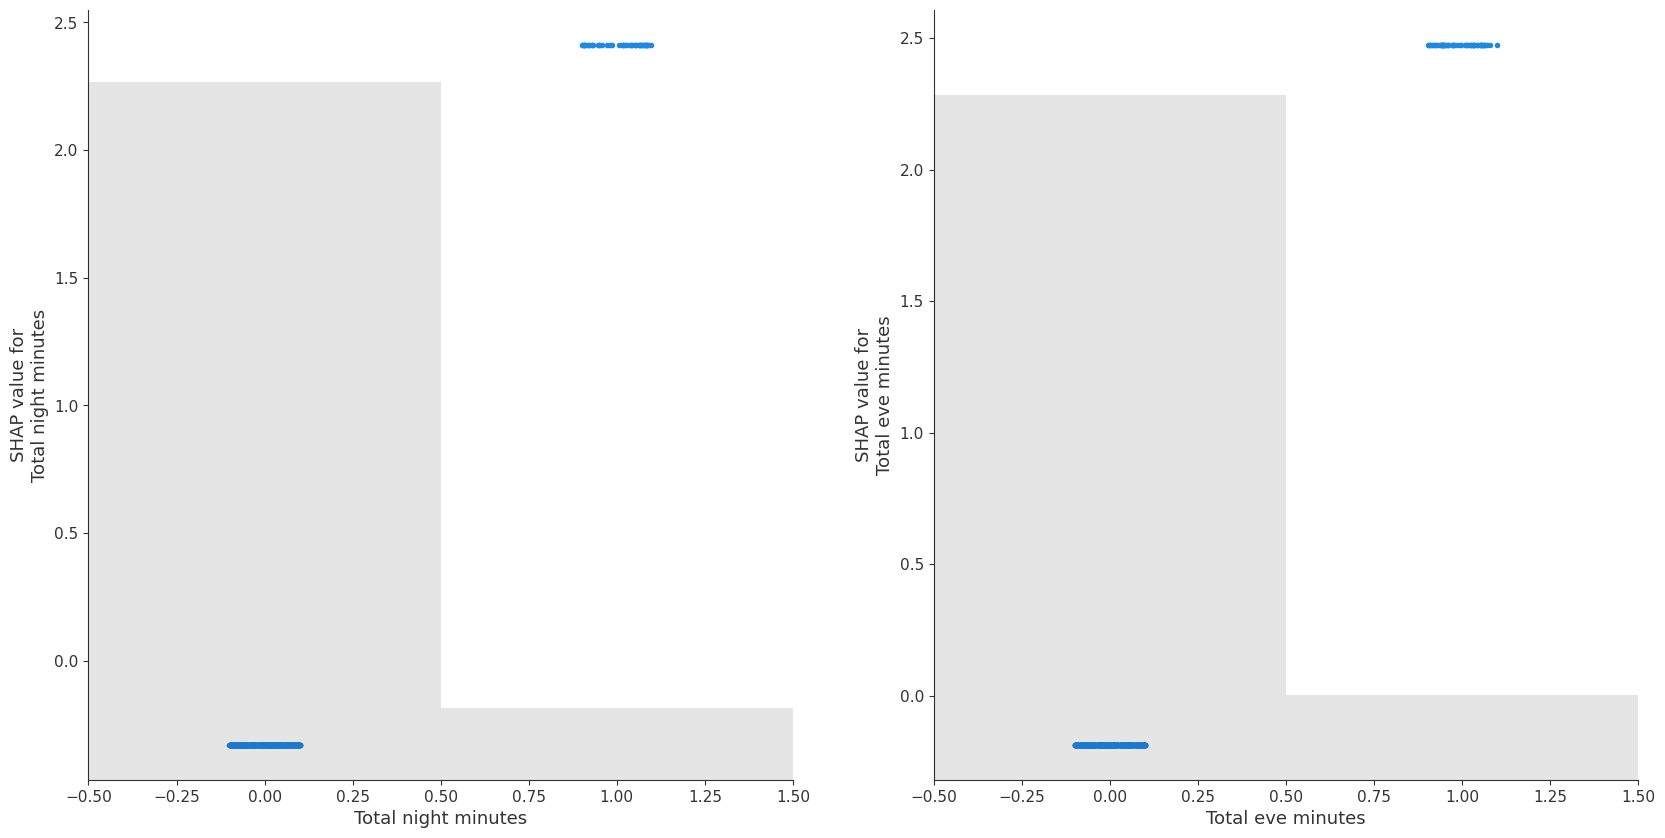

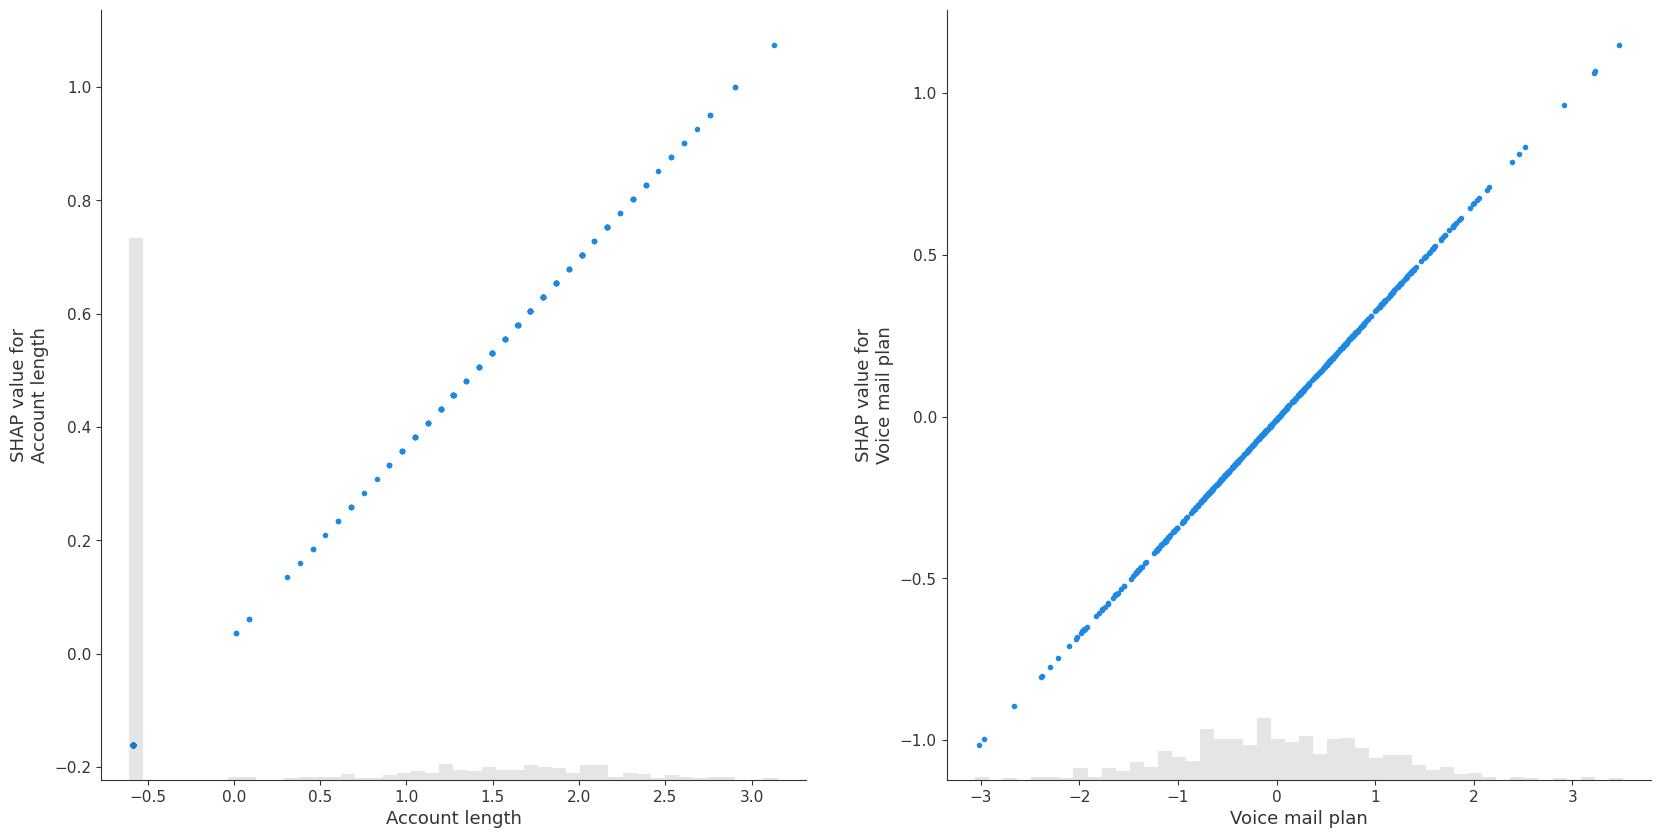

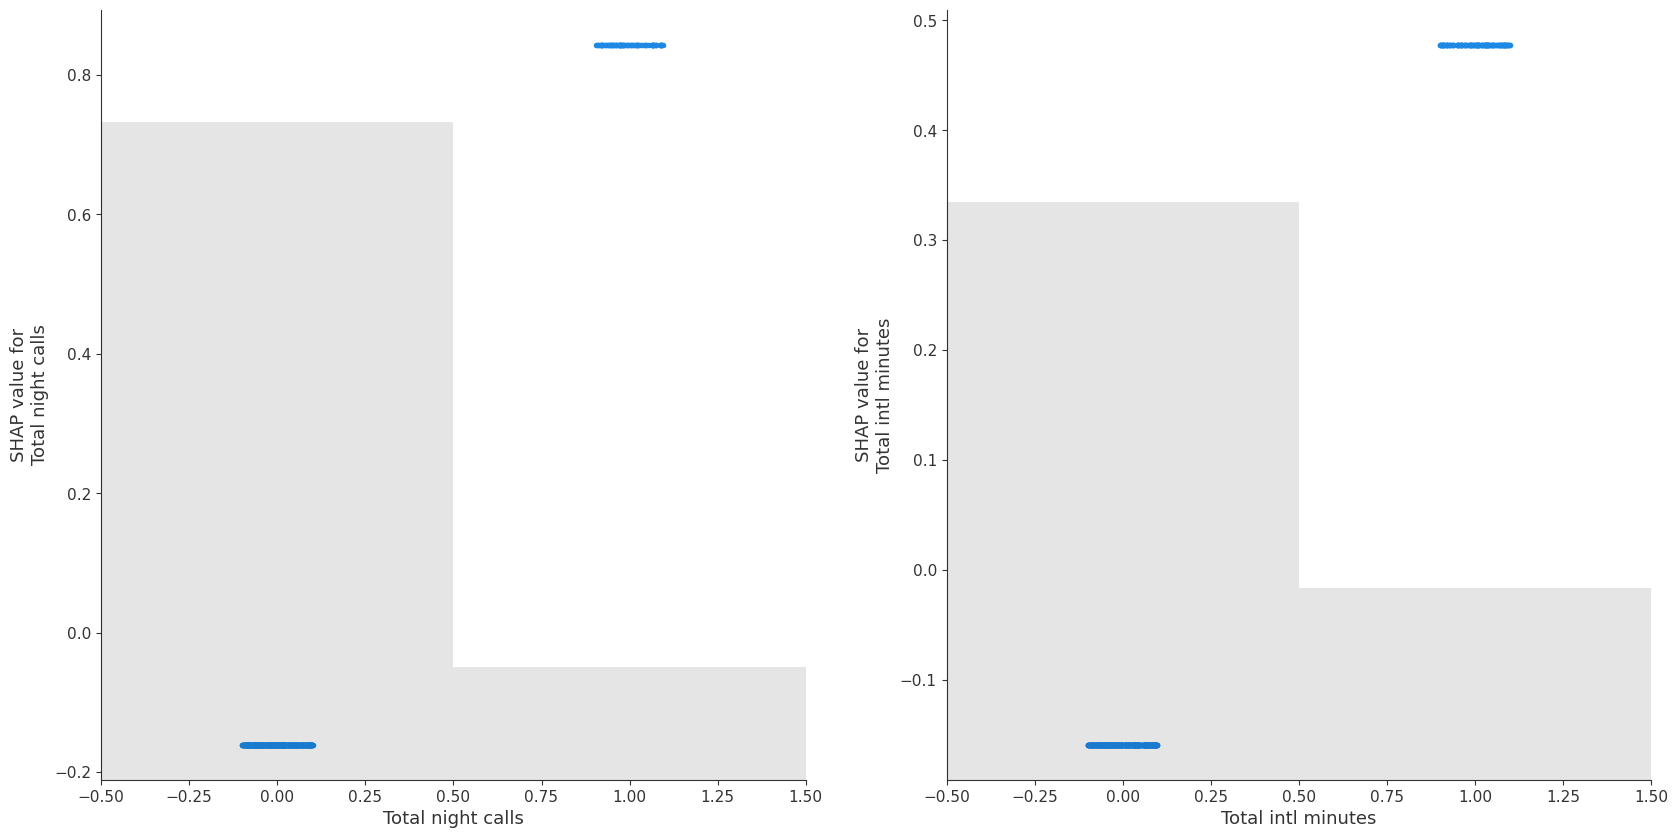

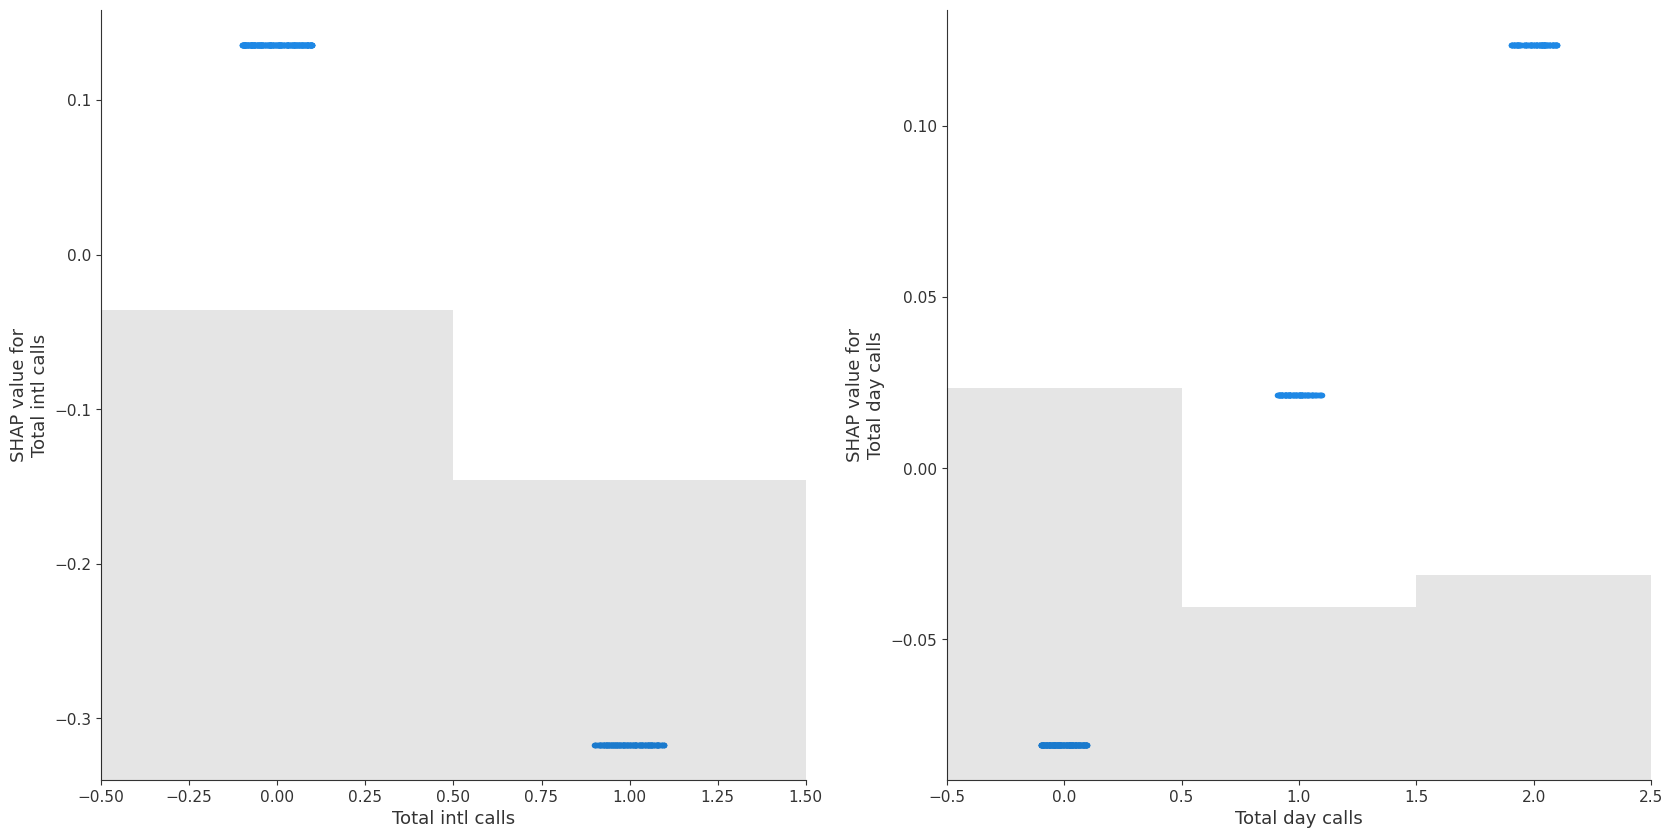

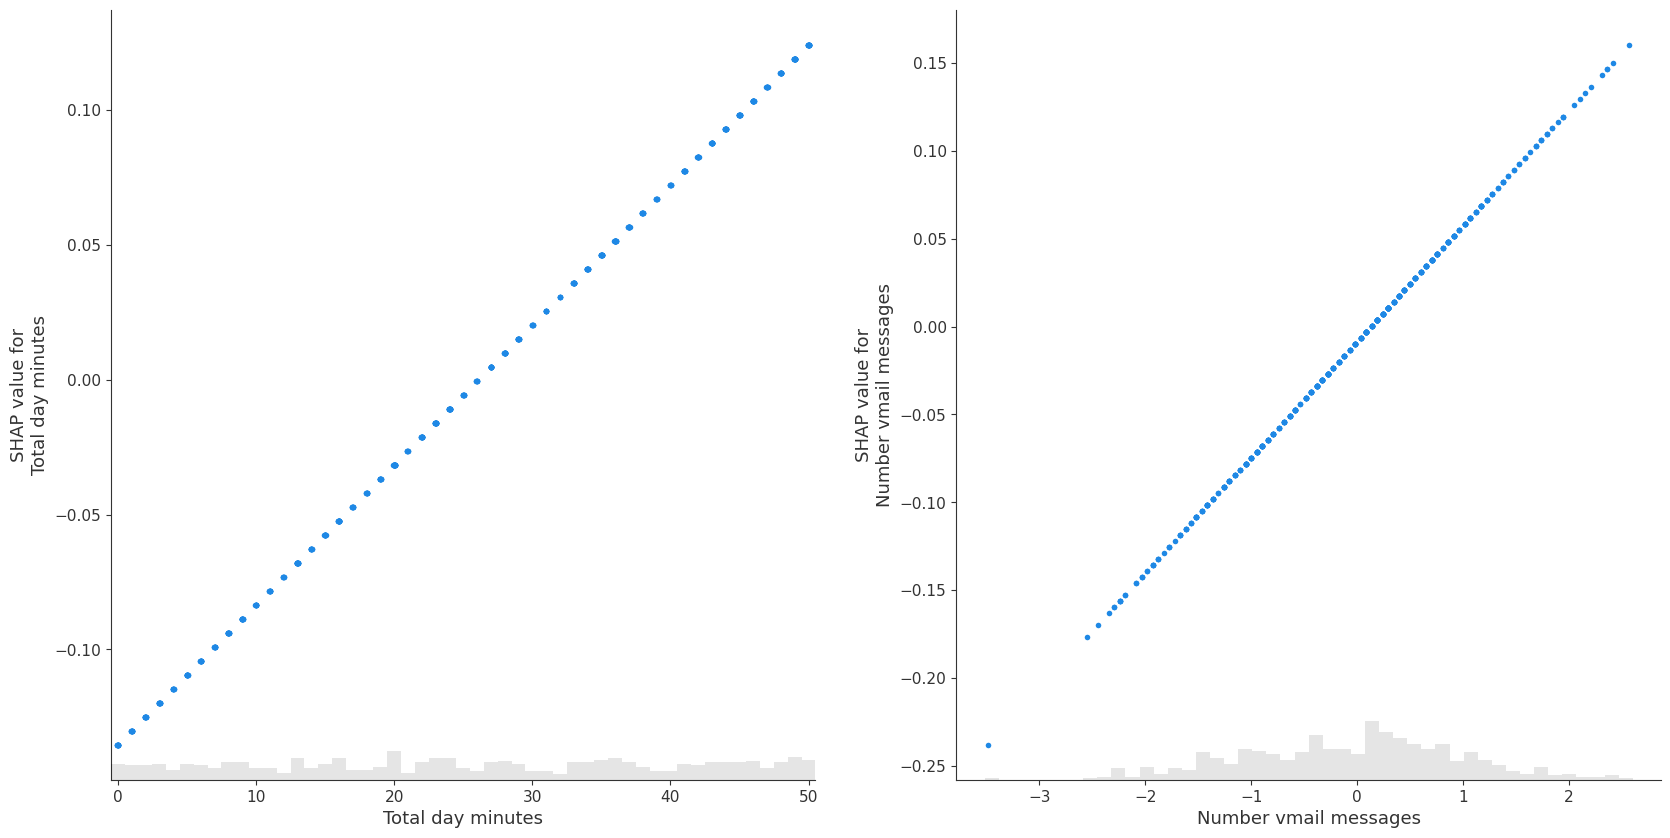

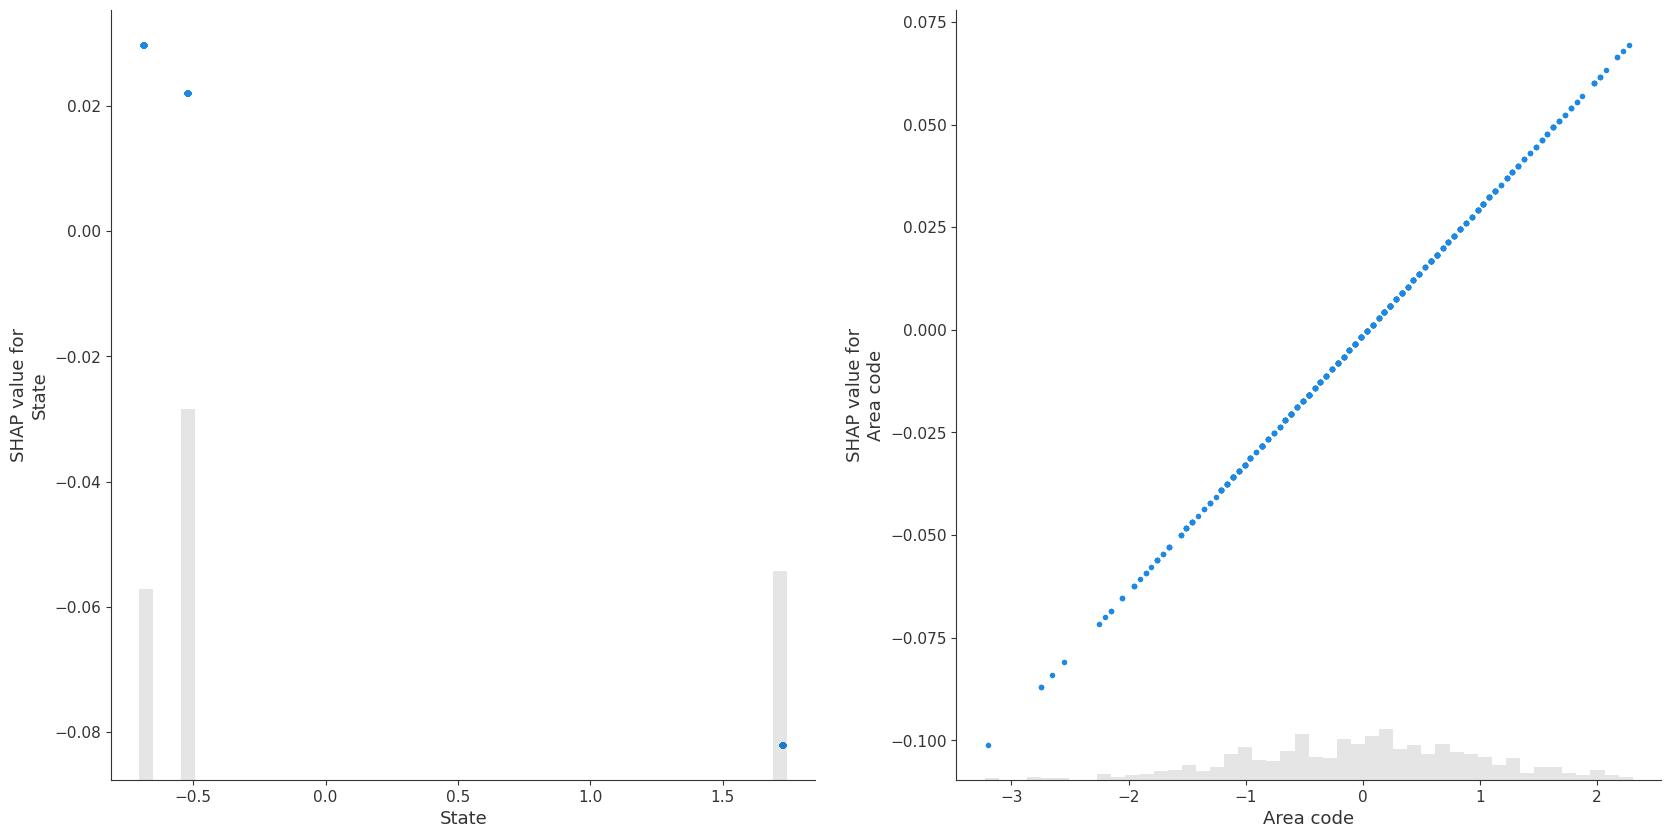

In [164]:
shap_scatter_lr(feature, shap_values['lr'])

Ces graphes montrent la distribution individuelle des shap values de chaque variable présente dans le graphe 'beeswarm' 